## Back order prediction

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc

import re
import pickle

from tqdm import tqdm
import os

import plotly.offline as offline
import plotly.graph_objs as go
offline.init_notebook_mode()
from collections import Counter
pd.set_option('display.max_columns', None)
from sklearn.preprocessing import MinMaxScaler 
from sklearn.manifold import TSNE
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from tabulate import tabulate
from sklearn.metrics import roc_auc_score

In [2]:
# Import the given training dataset
project_data = pd.read_csv('dataset/BackOrder.csv')
project_data.head(5)

sku  national_inv  lead_time  in_transit_qty  forecast_3_month  \
0  1026827           0.0        NaN             0.0               0.0   
1  1043384           2.0        9.0             0.0               0.0   
2  1043696           2.0        NaN             0.0               0.0   
3  1043852           7.0        8.0             0.0               0.0   
4  1044048           8.0        NaN             0.0               0.0   

   forecast_6_month  forecast_9_month  sales_1_month  sales_3_month  \
0               0.0               0.0            0.0            0.0   
1               0.0               0.0            0.0            0.0   
2               0.0               0.0            0.0            0.0   
3               0.0               0.0            0.0            0.0   
4               0.0               0.0            0.0            0.0   

   sales_6_month  sales_9_month  min_bank potential_issue  pieces_past_due  \
0            0.0            0.0       0.0              No              0.0   
1            0.0            0.0       0.0              No              0.0   
2            0.0            0.0       0.0              No              0.0   
3            0.0            0.0       1.0              No              0.0   
4            0.0            4.0       2.0              No              0.0   

   perf_6_month_avg  perf_12_month_avg  local_bo_qty deck_risk oe_constraint  \
0            -99.00             -99.00           0.0        No            No   
1              0.99               0.99           0.0        No            No   
2            -99.00             -99.00           0.0       Yes            No   
3              0.10               0.13           0.0        No            No   
4            -99.00             -99.00           0.0       Yes            No   

  ppap_risk stop_auto_buy rev_stop went_on_backorder  
0        No           Yes       No                No  
1        No           Yes       No                No  
2        No           Yes       No                No  
3        No           Yes       No                No  
4        No           Yes       No                No

In [3]:
project_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1687861 entries, 0 to 1687860
Data columns (total 23 columns):
sku                  1687861 non-null object
national_inv         1687860 non-null float64
lead_time            1586967 non-null float64
in_transit_qty       1687860 non-null float64
forecast_3_month     1687860 non-null float64
forecast_6_month     1687860 non-null float64
forecast_9_month     1687860 non-null float64
sales_1_month        1687860 non-null float64
sales_3_month        1687860 non-null float64
sales_6_month        1687860 non-null float64
sales_9_month        1687860 non-null float64
min_bank             1687860 non-null float64
potential_issue      1687860 non-null object
pieces_past_due      1687860 non-null float64
perf_6_month_avg     1687860 non-null float64
perf_12_month_avg    1687860 non-null float64
local_bo_qty         1687860 non-null float64
deck_risk            1687860 non-null object
oe_constraint        1687860 non-null object
ppap_risk        

### Column Details

- sku – Random ID for the product
- national_inv – Current inventory level for the part
- lead_time – Transit time for product (if available)
- in_transit_qty – Amount of product in transit from source
- forecast_3_month – Forecast sales for the next 3 months
- forecast_6_month – Forecast sales for the next 6 months
- forecast_9_month – Forecast sales for the next 9 months
- sales_1_month – Sales quantity for the prior 1 month time period
- sales_3_month – Sales quantity for the prior 3 month time period
- sales_6_month – Sales quantity for the prior 6 month time period
- sales_9_month – Sales quantity for the prior 9 month time period
- min_bank – Minimum recommend amount to stock
- potential_issue – Source issue for part identified
- pieces_past_due – Parts overdue from source
- perf_6_month_avg – Source performance for prior 6 month period
- perf_12_month_avg – Source performance for prior 12 month period
- local_bo_qty – Amount of stock orders overdue
- deck_risk – Part risk flag
- oe_constraint – Part risk flag
- ppap_risk – Part risk flag
- stop_auto_buy – Part risk flag
- rev_stop – Part risk flag
- went_on_backorder – Product actually went on backorder. This is the target value.

In [71]:
project_data.shape

(1687861, 23)

In [72]:
project_data.isnull().sum()

sku                       0
national_inv              1
lead_time            100894
in_transit_qty            1
forecast_3_month          1
forecast_6_month          1
forecast_9_month          1
sales_1_month             1
sales_3_month             1
sales_6_month             1
sales_9_month             1
min_bank                  1
potential_issue           1
pieces_past_due           1
perf_6_month_avg          1
perf_12_month_avg         1
local_bo_qty              1
deck_risk                 1
oe_constraint             1
ppap_risk                 1
stop_auto_buy             1
rev_stop                  1
went_on_backorder         1
dtype: int64

In [73]:
project_data['went_on_backorder'].value_counts()

No     1676567
Yes      11293
Name: went_on_backorder, dtype: int64

In [60]:
project_data['went_on_backorder'].isnull().sum()

1

In [76]:
project_data[project_data['went_on_backorder'].isnull()]

sku  national_inv  lead_time  in_transit_qty  \
1687860  (1687860 rows)           NaN        NaN             NaN   

         forecast_3_month  forecast_6_month  forecast_9_month  sales_1_month  \
1687860               NaN               NaN               NaN            NaN   

         sales_3_month  sales_6_month  sales_9_month  min_bank  \
1687860            NaN            NaN            NaN       NaN   

        potential_issue  pieces_past_due  perf_6_month_avg  perf_12_month_avg  \
1687860             NaN              NaN               NaN                NaN   

         local_bo_qty deck_risk oe_constraint ppap_risk stop_auto_buy  \
1687860           NaN       NaN           NaN       NaN           NaN   

        rev_stop went_on_backorder  
1687860      NaN               NaN

In [4]:
# lets drop the nan data from dataset
project_data = project_data.dropna(how='any', subset=['went_on_backorder'])

Backorder created  11293 , ( 0.6690720794378681 %)
Backorder not created  1676567 , ( 99.33092792056213 %)


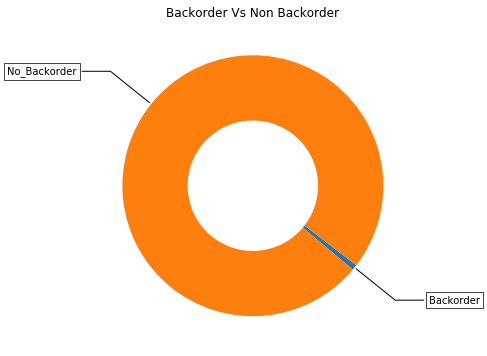

In [78]:
# https://matplotlib.org/gallery/pie_and_polar_charts/pie_and_donut_labels.html#sphx-glr-gallery-pie-and-polar-charts-pie-and-donut-labels-py

fail_counts = project_data['went_on_backorder'].value_counts()
print("Backorder created ", fail_counts[1], ", (", (fail_counts[1]/(fail_counts[1]+fail_counts[0]))*100,"%)")
print("Backorder not created ", fail_counts[0], ", (", (fail_counts[0]/(fail_counts[1]+fail_counts[0]))*100,"%)")

fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(aspect="equal"))
recipe = ["Backorder", "No_Backorder"]

fail_data = [fail_counts[1], fail_counts[0]]

wedges, texts = ax.pie(fail_data, wedgeprops=dict(width=0.5), startangle=-40)

bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
kw = dict(xycoords='data', textcoords='data', arrowprops=dict(arrowstyle="-"),
          bbox=bbox_props, zorder=0, va="center")

for i, p in enumerate(wedges):
    ang = (p.theta2 - p.theta1)/2. + p.theta1
    y = np.sin(np.deg2rad(ang))
    x = np.cos(np.deg2rad(ang))
    horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
    connectionstyle = "angle,angleA=0,angleB={}".format(ang)
    kw["arrowprops"].update({"connectionstyle": connectionstyle})
    ax.annotate(recipe[i], xy=(x, y), xytext=(1.35*np.sign(x), 1.4*y),
                 horizontalalignment=horizontalalignment, **kw)

ax.set_title("Backorder Vs Non Backorder")

plt.show()

In [79]:
project_data['went_on_backorder'].isnull().sum()

0

In [80]:
project_data.columns

Index(['sku', 'national_inv', 'lead_time', 'in_transit_qty',
       'forecast_3_month', 'forecast_6_month', 'forecast_9_month',
       'sales_1_month', 'sales_3_month', 'sales_6_month', 'sales_9_month',
       'min_bank', 'potential_issue', 'pieces_past_due', 'perf_6_month_avg',
       'perf_12_month_avg', 'local_bo_qty', 'deck_risk', 'oe_constraint',
       'ppap_risk', 'stop_auto_buy', 'rev_stop', 'went_on_backorder'],
      dtype='object')

In [5]:
col_objectType = [i for i in project_data.columns if (project_data[i].dtype == np.object) and (i not in ['sku']) ]

In [6]:
col_objectType

['potential_issue',
 'deck_risk',
 'oe_constraint',
 'ppap_risk',
 'stop_auto_buy',
 'rev_stop',
 'went_on_backorder']

In [7]:
for i in col_objectType:
    print('Unique values in {} : {}'.format(i,project_data[i].unique()))

Unique values in potential_issue : ['No' 'Yes']
Unique values in deck_risk : ['No' 'Yes']
Unique values in oe_constraint : ['No' 'Yes']
Unique values in ppap_risk : ['No' 'Yes']
Unique values in stop_auto_buy : ['Yes' 'No']
Unique values in rev_stop : ['No' 'Yes']
Unique values in went_on_backorder : ['No' 'Yes']


In [8]:
for i in col_objectType:
        project_data[i] = project_data[i].map({'No' : 0, 'Yes' : 1}).astype('int')

In [9]:
project_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1687860 entries, 0 to 1687859
Data columns (total 23 columns):
sku                  1687860 non-null object
national_inv         1687860 non-null float64
lead_time            1586967 non-null float64
in_transit_qty       1687860 non-null float64
forecast_3_month     1687860 non-null float64
forecast_6_month     1687860 non-null float64
forecast_9_month     1687860 non-null float64
sales_1_month        1687860 non-null float64
sales_3_month        1687860 non-null float64
sales_6_month        1687860 non-null float64
sales_9_month        1687860 non-null float64
min_bank             1687860 non-null float64
potential_issue      1687860 non-null int32
pieces_past_due      1687860 non-null float64
perf_6_month_avg     1687860 non-null float64
perf_12_month_avg    1687860 non-null float64
local_bo_qty         1687860 non-null float64
deck_risk            1687860 non-null int32
oe_constraint        1687860 non-null int32
ppap_risk           

In [86]:
project_data.isnull().sum()

sku                       0
national_inv              0
lead_time            100893
in_transit_qty            0
forecast_3_month          0
forecast_6_month          0
forecast_9_month          0
sales_1_month             0
sales_3_month             0
sales_6_month             0
sales_9_month             0
min_bank                  0
potential_issue           0
pieces_past_due           0
perf_6_month_avg          0
perf_12_month_avg         0
local_bo_qty              0
deck_risk                 0
oe_constraint             0
ppap_risk                 0
stop_auto_buy             0
rev_stop                  0
went_on_backorder         0
dtype: int64

In [138]:
project_data.head(5)

sku  national_inv  lead_time  in_transit_qty  forecast_3_month  \
0  1026827           0.0        NaN             0.0               0.0   
1  1043384           2.0        9.0             0.0               0.0   
2  1043696           2.0        NaN             0.0               0.0   
3  1043852           7.0        8.0             0.0               0.0   
4  1044048           8.0        NaN             0.0               0.0   

   forecast_6_month  forecast_9_month  sales_1_month  sales_3_month  \
0               0.0               0.0            0.0            0.0   
1               0.0               0.0            0.0            0.0   
2               0.0               0.0            0.0            0.0   
3               0.0               0.0            0.0            0.0   
4               0.0               0.0            0.0            0.0   

   sales_6_month  sales_9_month  min_bank  potential_issue  pieces_past_due  \
0            0.0            0.0       0.0                0              0.0   
1            0.0            0.0       0.0                0              0.0   
2            0.0            0.0       0.0                0              0.0   
3            0.0            0.0       1.0                0              0.0   
4            0.0            4.0       2.0                0              0.0   

   perf_6_month_avg  perf_12_month_avg  local_bo_qty  deck_risk  \
0            -99.00             -99.00           0.0          0   
1              0.99               0.99           0.0          0   
2            -99.00             -99.00           0.0          1   
3              0.10               0.13           0.0          0   
4            -99.00             -99.00           0.0          1   

   oe_constraint  ppap_risk  stop_auto_buy  rev_stop  went_on_backorder  
0              0          0              1         0                  0  
1              0          0              1         0                  0  
2              0          0              1         0                  0  
3              0          0              1         0                  0  
4              0          0              1         0                  0

## EDA

### National_inv

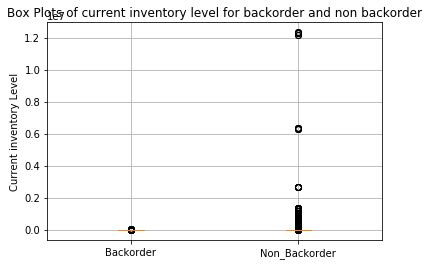

In [169]:
bck1 = project_data[project_data['went_on_backorder']==1]['national_inv'].values
bck2 = project_data[project_data['went_on_backorder']==0]['national_inv'].values

# https://glowingpython.blogspot.com/2012/09/boxplot-with-matplotlib.html
plt.boxplot([bck1, bck2])
plt.title('Box Plots of current inventory level for backorder and non backorder')
plt.xticks([1,2],('Backorder','Non_Backorder'))
plt.ylabel('Current inventory Level')
plt.grid()
plt.show()

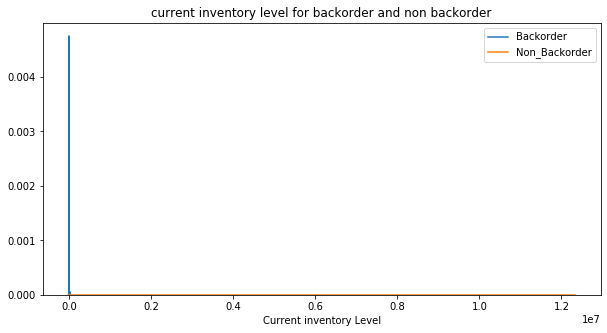

In [170]:
plt.figure(figsize=(10,5))
sns.distplot(bck1, hist=False, label="Backorder")
sns.distplot(bck2, hist=False, label="Non_Backorder")
plt.title('current inventory level for backorder and non backorder')
plt.xlabel('Current inventory Level')
plt.legend()
plt.show()

In [171]:
# http://zetcode.com/python/prettytable/
from prettytable import PrettyTable

x = PrettyTable()
x.field_names = ["Percentile", "BackOrder", "Non_Backorder"]

for i in range(0,101,5):
    x.add_row([i,np.round(np.percentile(bck1,i), 3), np.round(np.percentile(bck2,i), 3)])
print(x)

+------------+-----------+---------------+
| Percentile | BackOrder | Non_Backorder |
+------------+-----------+---------------+
|     0      |  -2999.0  |    -27256.0   |
|     5      |    -3.0   |      0.0      |
|     10     |    0.0    |      2.0      |
|     15     |    0.0    |      2.0      |
|     20     |    0.0    |      3.0      |
|     25     |    0.0    |      4.0      |
|     30     |    0.0    |      6.0      |
|     35     |    0.0    |      7.0      |
|     40     |    0.0    |      10.0     |
|     45     |    1.0    |      12.0     |
|     50     |    1.0    |      15.0     |
|     55     |    2.0    |      20.0     |
|     60     |    2.0    |      28.0     |
|     65     |    3.0    |      40.0     |
|     70     |    4.0    |      56.0     |
|     75     |    6.0    |      81.0     |
|     80     |    8.0    |     120.0     |
|     85     |    11.0   |     196.0     |
|     90     |    18.0   |     362.0     |
|     95     |    44.0   |     929.0     |
|    100   

In [172]:
x = PrettyTable()
x.field_names = ["Percentile", "BackOrder", "Non_Backorder"]
for i in range(95,101,1):
    x.add_row([i,np.round(np.percentile(bck1,i), 3), np.round(np.percentile(bck2,i), 3)])
print(x)

+------------+-----------+---------------+
| Percentile | BackOrder | Non_Backorder |
+------------+-----------+---------------+
|     95     |    44.0   |     929.0     |
|     96     |    58.0   |     1232.0    |
|     97     |    80.0   |     1834.0    |
|     98     |   112.0   |     3036.0    |
|     99     |   203.16  |     5506.0    |
|    100     |  29332.0  |   12334404.0  |
+------------+-----------+---------------+


In [173]:
x = PrettyTable()
x.field_names = ["Percentile", "BackOrder", "Non_Backorder"]
for i in range(0,11,1):
    x.add_row([(i*0.1)+99,np.round(np.percentile(bck1,(i*0.1)+99), 3), np.round(np.percentile(bck2,(i*0.1)+99), 3)])
print(x)

+------------+-----------+---------------+
| Percentile | BackOrder | Non_Backorder |
+------------+-----------+---------------+
|    99.0    |   203.16  |     5506.0    |
|    99.1    |  221.744  |     6131.0    |
|    99.2    |  233.992  |     6963.0    |
|    99.3    |  259.912  |     8006.0    |
|    99.4    |  287.248  |    9416.812   |
|    99.5    |   327.78  |    11129.0    |
|    99.6    |  418.464  |   13707.944   |
|    99.7    |   514.0   |    17352.0    |
|    99.8    |  663.488  |    24590.0    |
|    99.9    |  2064.788 |   41655.434   |
|   100.0    |  29332.0  |   12334404.0  |
+------------+-----------+---------------+


In [178]:
bck1_99 = [i for i in bck1 if i<2065 ]
bck2_99 = [i for i in bck2 if i<41656 ]

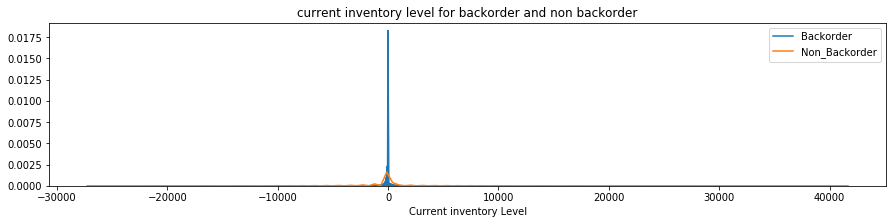

In [179]:
plt.figure(figsize=(15,3))
sns.distplot(bck1_99, hist=False, label="Backorder")
sns.distplot(bck2_99, hist=False, label="Non_Backorder")
plt.title('current inventory level for backorder and non backorder')
plt.xlabel('Current inventory Level')
plt.legend()
plt.show()

In [176]:
project_data.shape[0] - len(bck1_99+bck2_99)

1689

### Lead_time

In [127]:
print("Total {} % data are null in lead_time - (Total : {}, Nan data count : {})" 
      .format(project_data['lead_time'].isnull().sum()*100/project_data.shape[0], 
             project_data.shape[0], project_data['lead_time'].isnull().sum()))

Total 5.9775692296754475 % data are null in lead_time - (Total : 1687860, Nan data count : 100893)


In [137]:
temp1 = project_data[project_data['lead_time'].isnull()]['went_on_backorder']
temp1.value_counts()

0    100569
1       324
Name: went_on_backorder, dtype: int64

In [140]:
temp2 = project_data[~project_data['lead_time'].isnull()]

In [143]:
temp2.head()

sku  national_inv  lead_time  in_transit_qty  forecast_3_month  \
1  1043384           2.0        9.0             0.0               0.0   
3  1043852           7.0        8.0             0.0               0.0   
5  1044198          13.0        8.0             0.0               0.0   
7  1045098           6.0        2.0             0.0               0.0   
9  1045867           4.0        8.0             0.0               0.0   

   forecast_6_month  forecast_9_month  sales_1_month  sales_3_month  \
1               0.0               0.0            0.0            0.0   
3               0.0               0.0            0.0            0.0   
5               0.0               0.0            0.0            0.0   
7               0.0               0.0            0.0            0.0   
9               0.0               0.0            0.0            0.0   

   sales_6_month  sales_9_month  min_bank  potential_issue  pieces_past_due  \
1            0.0            0.0       0.0                0              0.0   
3            0.0            0.0       1.0                0              0.0   
5            0.0            0.0       0.0                0              0.0   
7            0.0            0.0       0.0                0              0.0   
9            0.0            0.0       0.0                0              0.0   

   perf_6_month_avg  perf_12_month_avg  local_bo_qty  deck_risk  \
1              0.99               0.99           0.0          0   
3              0.10               0.13           0.0          0   
5              0.82               0.87           0.0          0   
7              0.00               0.00           0.0          1   
9              0.82               0.87           0.0          0   

   oe_constraint  ppap_risk  stop_auto_buy  rev_stop  went_on_backorder  
1              0          0              1         0                  0  
3              0          0              1         0                  0  
5              0          0              1         0                  0  
7              0          1              1         0                  0  
9              0          0              1         0                  0

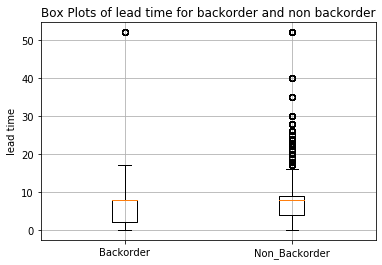

In [145]:
bck1 = temp2[temp2['went_on_backorder']==1]['lead_time'].values
bck2 = temp2[temp2['went_on_backorder']==0]['lead_time'].values

# https://glowingpython.blogspot.com/2012/09/boxplot-with-matplotlib.html
plt.boxplot([bck1, bck2])
plt.title('Box Plots of lead time for backorder and non backorder')
plt.xticks([1,2],('Backorder','Non_Backorder'))
plt.ylabel('lead time')
plt.grid()
plt.show()

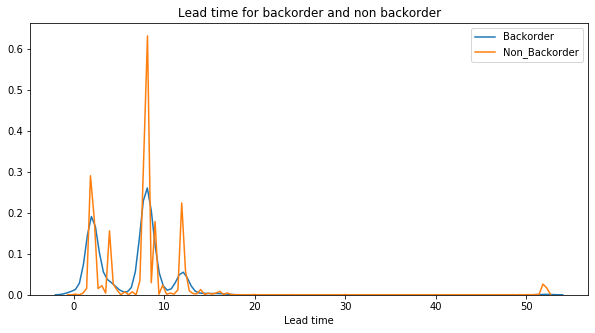

In [146]:
plt.figure(figsize=(10,5))
sns.distplot(bck1, hist=False, label="Backorder")
sns.distplot(bck2, hist=False, label="Non_Backorder")
plt.title('Lead time for backorder and non backorder')
plt.xlabel('Lead time')
plt.legend()
plt.show()

In [147]:
# http://zetcode.com/python/prettytable/
from prettytable import PrettyTable

x = PrettyTable()
x.field_names = ["Percentile", "BackOrder", "Non_Backorder"]

for i in range(0,101,5):
    x.add_row([i,np.round(np.percentile(bck1,i), 3), np.round(np.percentile(bck2,i), 3)])
print(x)

+------------+-----------+---------------+
| Percentile | BackOrder | Non_Backorder |
+------------+-----------+---------------+
|     0      |    0.0    |      0.0      |
|     5      |    2.0    |      2.0      |
|     10     |    2.0    |      2.0      |
|     15     |    2.0    |      2.0      |
|     20     |    2.0    |      2.0      |
|     25     |    2.0    |      4.0      |
|     30     |    2.0    |      4.0      |
|     35     |    4.0    |      8.0      |
|     40     |    6.0    |      8.0      |
|     45     |    8.0    |      8.0      |
|     50     |    8.0    |      8.0      |
|     55     |    8.0    |      8.0      |
|     60     |    8.0    |      8.0      |
|     65     |    8.0    |      8.0      |
|     70     |    8.0    |      8.0      |
|     75     |    8.0    |      9.0      |
|     80     |    8.0    |      9.0      |
|     85     |    9.0    |      12.0     |
|     90     |    12.0   |      12.0     |
|     95     |    12.0   |      12.0     |
|    100   

In [148]:
x = PrettyTable()
x.field_names = ["Percentile", "BackOrder", "Non_Backorder"]
for i in range(95,101,1):
    x.add_row([i,np.round(np.percentile(bck1,i), 3), np.round(np.percentile(bck2,i), 3)])
print(x)

+------------+-----------+---------------+
| Percentile | BackOrder | Non_Backorder |
+------------+-----------+---------------+
|     95     |    12.0   |      12.0     |
|     96     |    12.0   |      13.0     |
|     97     |    12.0   |      15.0     |
|     98     |    12.0   |      18.0     |
|     99     |    14.0   |      52.0     |
|    100     |    52.0   |      52.0     |
+------------+-----------+---------------+


### in transit Quantity

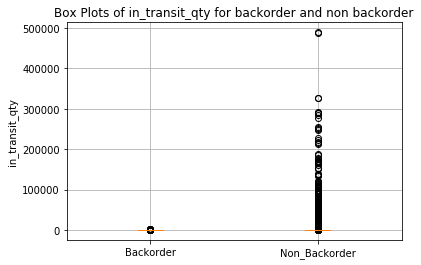

In [180]:
bck1 = project_data[project_data['went_on_backorder']==1]['in_transit_qty'].values
bck2 = project_data[project_data['went_on_backorder']==0]['in_transit_qty'].values

# https://glowingpython.blogspot.com/2012/09/boxplot-with-matplotlib.html
plt.boxplot([bck1, bck2])
plt.title('Box Plots of in_transit_qty for backorder and non backorder')
plt.xticks([1,2],('Backorder','Non_Backorder'))
plt.ylabel('in_transit_qty')
plt.grid()
plt.show()

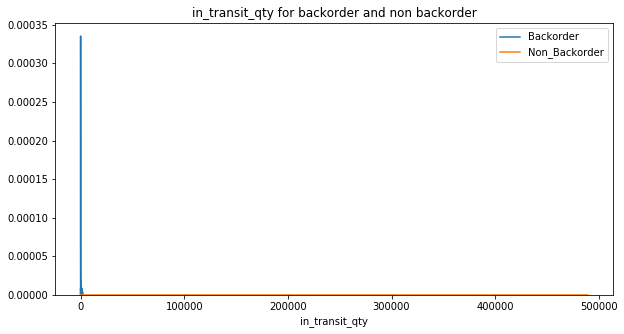

In [181]:
plt.figure(figsize=(10,5))
sns.distplot(bck1, hist=False, label="Backorder")
sns.distplot(bck2, hist=False, label="Non_Backorder")
plt.title('in_transit_qty for backorder and non backorder')
plt.xlabel('in_transit_qty')
plt.legend()
plt.show()

In [182]:
# http://zetcode.com/python/prettytable/
from prettytable import PrettyTable

x = PrettyTable()
x.field_names = ["Percentile", "BackOrder", "Non_Backorder"]

for i in range(0,101,5):
    x.add_row([i,np.round(np.percentile(bck1,i), 3), np.round(np.percentile(bck2,i), 3)])
print(x)

+------------+-----------+---------------+
| Percentile | BackOrder | Non_Backorder |
+------------+-----------+---------------+
|     0      |    0.0    |      0.0      |
|     5      |    0.0    |      0.0      |
|     10     |    0.0    |      0.0      |
|     15     |    0.0    |      0.0      |
|     20     |    0.0    |      0.0      |
|     25     |    0.0    |      0.0      |
|     30     |    0.0    |      0.0      |
|     35     |    0.0    |      0.0      |
|     40     |    0.0    |      0.0      |
|     45     |    0.0    |      0.0      |
|     50     |    0.0    |      0.0      |
|     55     |    0.0    |      0.0      |
|     60     |    0.0    |      0.0      |
|     65     |    0.0    |      0.0      |
|     70     |    0.0    |      0.0      |
|     75     |    0.0    |      0.0      |
|     80     |    0.0    |      1.0      |
|     85     |    0.0    |      4.0      |
|     90     |    1.0    |      16.0     |
|     95     |    8.0    |      68.0     |
|    100   

In [183]:
x = PrettyTable()
x.field_names = ["Percentile", "BackOrder", "Non_Backorder"]
for i in range(95,101,1):
    x.add_row([i,np.round(np.percentile(bck1,i), 3), np.round(np.percentile(bck2,i), 3)])
print(x)

+------------+-----------+---------------+
| Percentile | BackOrder | Non_Backorder |
+------------+-----------+---------------+
|     95     |    8.0    |      68.0     |
|     96     |    12.0   |      99.0     |
|     97     |    20.0   |     150.0     |
|     98     |    39.0   |     254.0     |
|     99     |   81.16   |     574.0     |
|    100     |   2259.0  |    489408.0   |
+------------+-----------+---------------+


In [184]:
x = PrettyTable()
x.field_names = ["Percentile", "BackOrder", "Non_Backorder"]
for i in range(0,11,1):
    x.add_row([(i*0.1)+99,np.round(np.percentile(bck1,(i*0.1)+99), 3), np.round(np.percentile(bck2,(i*0.1)+99), 3)])
print(x)

+------------+-----------+---------------+
| Percentile | BackOrder | Non_Backorder |
+------------+-----------+---------------+
|    99.0    |   81.16   |     574.0     |
|    99.1    |   90.372  |     640.0     |
|    99.2    |   104.0   |     724.0     |
|    99.3    |  118.956  |     840.0     |
|    99.4    |  133.496  |     1000.0    |
|    99.5    |   152.0   |     1203.0    |
|    99.6    |   180.0   |     1520.0    |
|    99.7    |  242.372  |     2063.0    |
|    99.8    |  354.992  |    3013.868   |
|    99.9    |  706.708  |    5588.246   |
|   100.0    |   2259.0  |    489408.0   |
+------------+-----------+---------------+


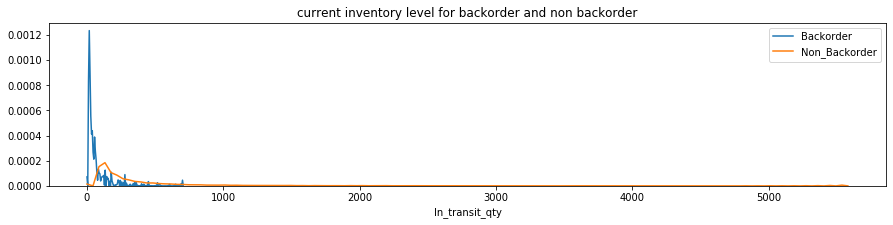

In [185]:
bck1_99 = [i for i in bck1 if i<707 ]
bck2_99 = [i for i in bck2 if i<5589 ]

plt.figure(figsize=(15,3))
sns.distplot(bck1_99, hist=False, label="Backorder")
sns.distplot(bck2_99, hist=False, label="Non_Backorder")
plt.title('current inventory level for backorder and non backorder')
plt.xlabel('In_transit_qty')
plt.legend()
plt.show()

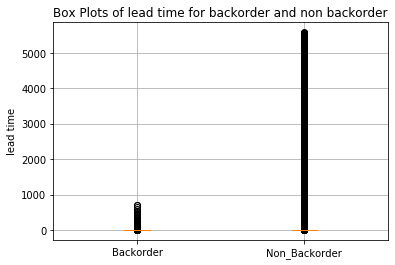

In [187]:
# https://glowingpython.blogspot.com/2012/09/boxplot-with-matplotlib.html
plt.boxplot([bck1_99, bck2_99])
plt.title('Box Plots of lead time for backorder and non backorder')
plt.xticks([1,2],('Backorder','Non_Backorder'))
plt.ylabel('lead time')
plt.grid()
plt.show()

In [186]:
project_data.shape[0] - len(bck1_99+bck2_99)

1689

### Forecast of 3,6 and 9 month

In [241]:
col = ['forecast_3_month','forecast_6_month','forecast_9_month','went_on_backorder']

In [242]:
# Define function for violin plot for new features with target values

def bivariate_plot(df, title, col):
    sns.set(font_scale = 0.8)
    fig, axs = plt.subplots(figsize =(15, 4), ncols=col, nrows=1) 
    tar = df['went_on_backorder']
    col_name = list(df.columns.values)[:-1]
    for i,ax in zip(col_name,axs.flat):
        sns.violinplot(ax = ax, x = tar,  y = df[i]).set_title(i)
    #fig.delaxes(axs[1][3])
    handles, labels = ax.get_legend_handles_labels()
    plt.legend(handles, labels, loc='upper center')
    plt.suptitle(title)  
    plt.show()

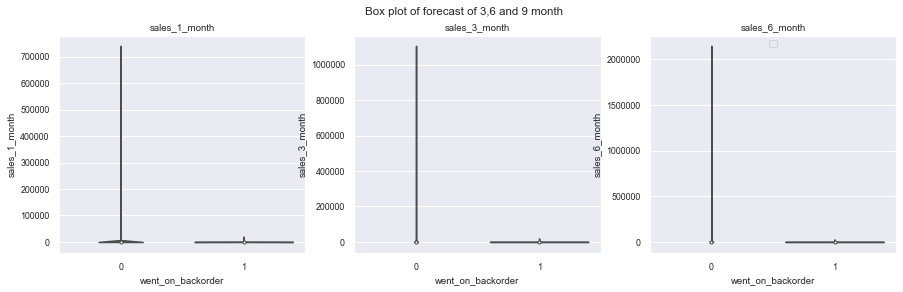

In [211]:
# plot violin plot for each sensor on max change
title = 'Box plot of forecast of 3,6 and 9 month'

bivariate_plot(project_data[col], title, 3)

In [247]:
for j in col[:-1]:
    print('=='*21)
    print('{} column '.format(j))
    
    x = PrettyTable()
    x.field_names = ["Percentile", "BackOrder", "Non_Backorder"]
    bck1 = project_data[project_data['went_on_backorder']==1][j].values
    bck2 = project_data[project_data['went_on_backorder']==0][j].values
    for i in range(0,11,1):
        x.add_row([(i*0.1)+99,np.round(np.percentile(bck1,(i*0.1)+99), 3), np.round(np.percentile(bck2,(i*0.1)+99), 3)])
    print(x)


forecast_3_month column 
+------------+-----------+---------------+
| Percentile | BackOrder | Non_Backorder |
+------------+-----------+---------------+
|    99.0    |  2139.76  |     2287.0    |
|    99.1    |  2405.952 |     2544.0    |
|    99.2    |   2992.0  |     2886.0    |
|    99.3    |  3164.752 |     3285.0    |
|    99.4    |   3454.0  |     3864.0    |
|    99.5    |   3787.0  |    4610.68    |
|    99.6    |  4767.48  |    5857.472   |
|    99.7    |   7419.0  |     7900.0    |
|    99.8    |  9618.144 |   11617.604   |
|    99.9    |  15000.0  |   21466.208   |
|   100.0    |  120000.0 |   1427612.0   |
+------------+-----------+---------------+
forecast_6_month column 
+------------+-----------+---------------+
| Percentile | BackOrder | Non_Backorder |
+------------+-----------+---------------+
|    99.0    |  3344.64  |    4343.34    |
|    99.1    |   3600.0  |     4908.0    |
|    99.2    |  3810.624 |    5412.472   |
|    99.3    |  4728.788 |     6100.0    |
|   

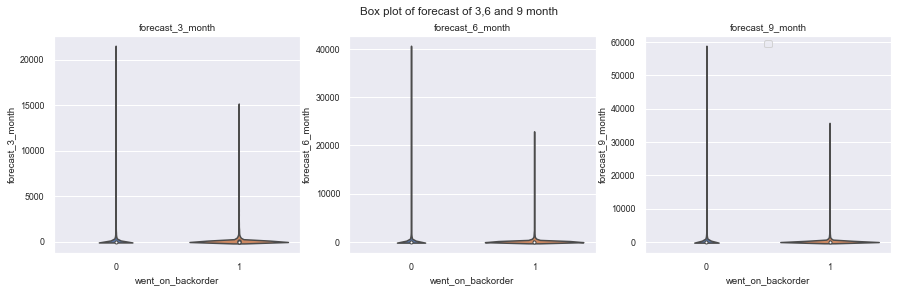

In [278]:
temp = project_data[((project_data['went_on_backorder']==1) & (project_data['forecast_3_month'] <=15000) & (project_data['forecast_6_month'] <=22924) & (project_data['forecast_9_month'] <=35371)) | ((project_data['went_on_backorder']==0) & (project_data['forecast_3_month'] <=21567) & (project_data['forecast_6_month'] <=41004) & (project_data['forecast_9_month'] <=58694))]


# plot violin plot for each sensor on max change
title = 'Box plot of forecast of 3,6 and 9 month'

bivariate_plot(temp[col], title, 3)

In [277]:
temp.shape

(1685959, 23)

### Sales of 1,3,6 and 9 month

In [279]:
col = ['sales_1_month','sales_3_month','sales_6_month','sales_9_month','went_on_backorder']

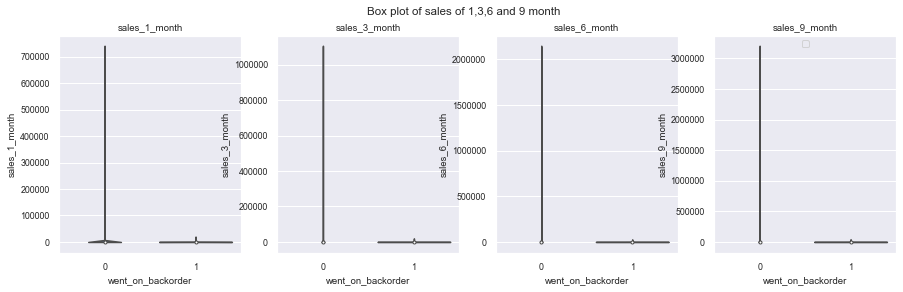

In [212]:
# plot violin plot for each sensor on max change
title = 'Box plot of sales of 1,3,6 and 9 month'

bivariate_plot(project_data[col], title, 4)

In [280]:
for j in col[:-1]:
    print('=='*21)
    print('{} column '.format(j))
    
    x = PrettyTable()
    x.field_names = ["Percentile", "BackOrder", "Non_Backorder"]
    bck1 = project_data[project_data['went_on_backorder']==1][j].values
    bck2 = project_data[project_data['went_on_backorder']==0][j].values
    for i in range(0,11,1):
        x.add_row([(i*0.1)+99,np.round(np.percentile(bck1,(i*0.1)+99), 3), np.round(np.percentile(bck2,(i*0.1)+99), 3)])
    print(x)


sales_1_month column 
+------------+-----------+---------------+
| Percentile | BackOrder | Non_Backorder |
+------------+-----------+---------------+
|    99.0    |   474.0   |     701.0     |
|    99.1    |   501.86  |     773.0     |
|    99.2    |  521.976  |     861.0     |
|    99.3    |  541.912  |     976.0     |
|    99.4    |  568.744  |    1116.604   |
|    99.5    |   690.26  |     1314.0    |
|    99.6    |  852.928  |     1640.0    |
|    99.7    |  1048.556 |    2199.302   |
|    99.8    |   2010.0  |     3165.0    |
|    99.9    |  2818.976 |    5841.302   |
|   100.0    |  20005.0  |    741774.0   |
+------------+-----------+---------------+
sales_3_month column 
+------------+-----------+---------------+
| Percentile | BackOrder | Non_Backorder |
+------------+-----------+---------------+
|    99.0    |  1287.28  |     2242.0    |
|    99.1    |  1472.976 |     2486.0    |
|    99.2    |  1564.664 |    2764.472   |
|    99.3    |  1641.824 |     3124.0    |
|    99.4 

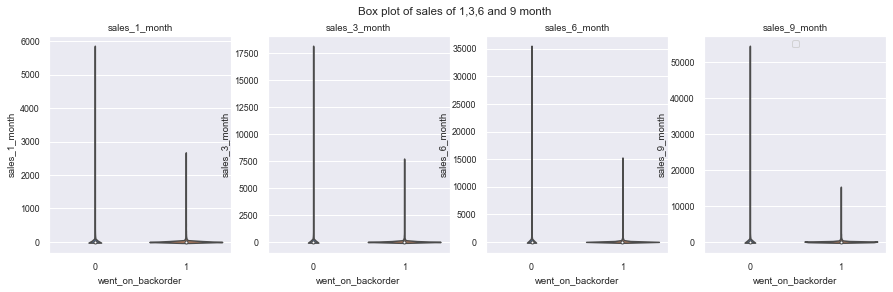

In [281]:
temp = project_data[((project_data['went_on_backorder']==1) & (project_data['sales_1_month'] <=2819) & (project_data['sales_3_month'] <=9040) & (project_data['sales_6_month'] <=15557) & (project_data['sales_9_month'] <=21650)) | ((project_data['went_on_backorder']==0) & (project_data['sales_1_month'] <=5842) & (project_data['sales_3_month'] <=18169) & (project_data['sales_6_month'] <=35437) & (project_data['sales_9_month'] <=54397))]

# plot violin plot for each sensor on max change
title = 'Box plot of sales of 1,3,6 and 9 month'

bivariate_plot(temp[col], title, 4)

### Min bank

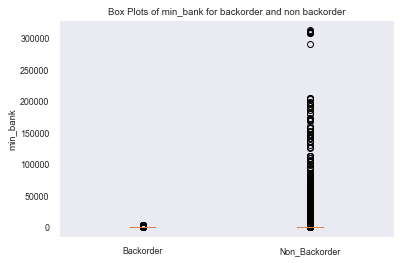

In [232]:
bck1 = project_data[project_data['went_on_backorder']==1]['min_bank'].values
bck2 = project_data[project_data['went_on_backorder']==0]['min_bank'].values

# https://glowingpython.blogspot.com/2012/09/boxplot-with-matplotlib.html
plt.boxplot([bck1, bck2])
plt.title('Box Plots of min_bank for backorder and non backorder')
plt.xticks([1,2],('Backorder','Non_Backorder'))
plt.ylabel('min_bank')
plt.grid()
plt.show()

In [238]:
x = PrettyTable()
x.field_names = ["Percentile", "BackOrder", "Non_Backorder"]
for i in range(0,11,1):
    x.add_row([(i*0.1)+99,np.round(np.percentile(bck1,(i*0.1)+99), 3), np.round(np.percentile(bck2,(i*0.1)+99), 3)])
print(x)

+------------+-----------+---------------+
| Percentile | BackOrder | Non_Backorder |
+------------+-----------+---------------+
|    99.0    |   427.48  |     681.0     |
|    99.1    |   465.86  |     750.0     |
|    99.2    |  496.968  |     833.0     |
|    99.3    |  550.956  |     949.0     |
|    99.4    |  596.248  |     1086.0    |
|    99.5    |   673.62  |     1288.0    |
|    99.6    |  890.496  |     1620.0    |
|    99.7    |  1299.24  |    2128.302   |
|    99.8    |  1719.768 |    3004.868   |
|    99.9    |  2231.932 |    5656.17    |
|   100.0    |   4342.0  |    313319.0   |
+------------+-----------+---------------+


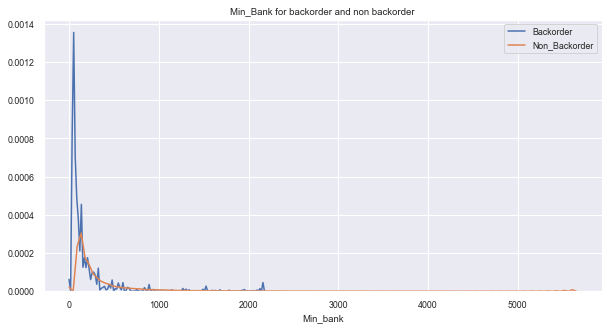

In [240]:
bck1_99 = [i for i in bck1 if i<2232 ]
bck2_99 = [i for i in bck2 if i<5657 ]

plt.figure(figsize=(10,5))
sns.distplot(bck1_99, hist=False, label="Backorder")
sns.distplot(bck2_99, hist=False, label="Non_Backorder")
plt.title('Min_Bank for backorder and non backorder')
plt.xlabel('Min_bank')
plt.legend()
plt.show()

### potential_issue

In [284]:
project_data['potential_issue'].value_counts()

0    1686953
1        907
Name: potential_issue, dtype: int64

In [288]:
#stacked bar plots matplotlib: https://matplotlib.org/gallery/lines_bars_and_markers/bar_stacked.html
def stack_plot(data, title, xtick, col2='went_on_backorder', col3='total'):
    ind = np.arange(data.shape[0])
    
    plt.figure(figsize=(20,5))
    p1 = plt.bar(ind, data[col3].values)
    p2 = plt.bar(ind, data[col2].values)

    plt.ylabel('Orders')
    plt.title(title)
    plt.xticks(ind, list(data[xtick].values))
    plt.legend((p1[0], p2[0]), ('total orders', 'Backorders'))
    plt.show()

In [293]:
def univariate_barplots(data,title, col1, col2='went_on_backorder', top=False):
    # Count number of zeros in dataframe python: https://stackoverflow.com/a/51540521/4084039
    temp = pd.DataFrame(project_data.groupby(col1)[col2].agg(lambda x: x.eq(1).sum())).reset_index()

    # Pandas dataframe grouby count: https://stackoverflow.com/a/19385591/4084039
    temp['total'] = pd.DataFrame(project_data.groupby(col1)[col2].agg({'total':'count'})).reset_index()['total']
    temp['Avg'] = pd.DataFrame(project_data.groupby(col1)[col2].agg({'Avg':'mean'})).reset_index()['Avg']
    
    temp.sort_values(by=['total'],inplace=True, ascending=False)
    
    if top:
        temp = temp[0:top]
    
    stack_plot(temp, title, xtick=col1, col2=col2, col3='total')
    #print(temp.head(5))
    print("="*60)
    print(temp)

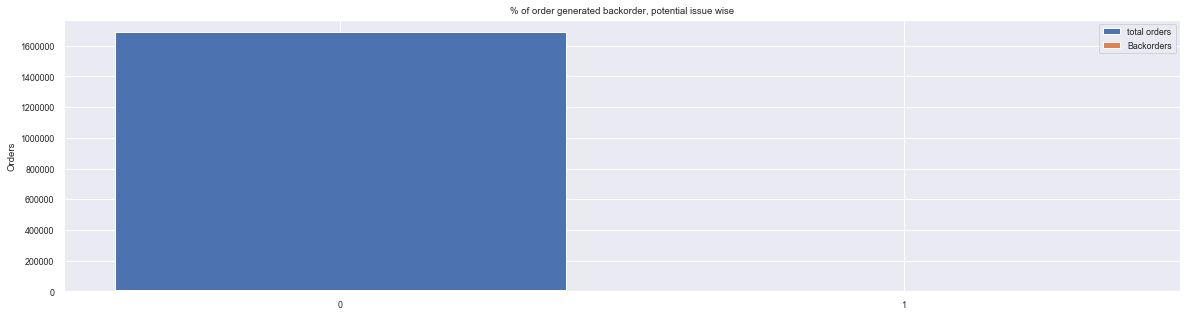

   potential_issue  went_on_backorder    total       Avg
0                0              11242  1686953  0.006664
1                1                 51      907  0.056229


In [294]:
title = '% of order generated backorder, potential issue wise'
univariate_barplots(project_data, title, 'potential_issue', 'went_on_backorder', False)

### pieces_past_due

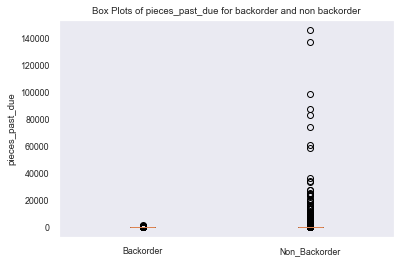

In [295]:
bck1 = project_data[project_data['went_on_backorder']==1]['pieces_past_due'].values
bck2 = project_data[project_data['went_on_backorder']==0]['pieces_past_due'].values

# https://glowingpython.blogspot.com/2012/09/boxplot-with-matplotlib.html
plt.boxplot([bck1, bck2])
plt.title('Box Plots of pieces_past_due for backorder and non backorder')
plt.xticks([1,2],('Backorder','Non_Backorder'))
plt.ylabel('pieces_past_due')
plt.grid()
plt.show()

In [296]:
x = PrettyTable()
x.field_names = ["Percentile", "BackOrder", "Non_Backorder"]
for i in range(0,11,1):
    x.add_row([(i*0.1)+99,np.round(np.percentile(bck1,(i*0.1)+99), 3), np.round(np.percentile(bck2,(i*0.1)+99), 3)])
print(x)

+------------+-----------+---------------+
| Percentile | BackOrder | Non_Backorder |
+------------+-----------+---------------+
|    99.0    |    72.0   |      4.0      |
|    99.1    |    80.0   |      5.0      |
|    99.2    |    84.0   |      8.0      |
|    99.3    |    90.0   |      11.0     |
|    99.4    |   100.0   |      16.0     |
|    99.5    |   120.0   |      23.0     |
|    99.6    |  149.328  |      34.0     |
|    99.7    |   200.0   |      54.0     |
|    99.8    |  258.392  |     100.0     |
|    99.9    |   600.0   |     235.0     |
|   100.0    |   1488.0  |    146496.0   |
+------------+-----------+---------------+


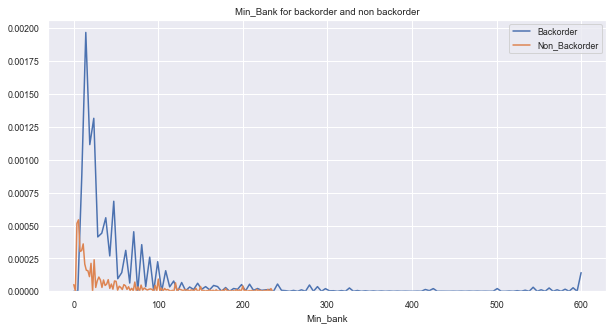

In [297]:
bck1_99 = [i for i in bck1 if i<601 ]
bck2_99 = [i for i in bck2 if i<236 ]

plt.figure(figsize=(10,5))
sns.distplot(bck1_99, hist=False, label="Backorder")
sns.distplot(bck2_99, hist=False, label="Non_Backorder")
plt.title('Min_Bank for backorder and non backorder')
plt.xlabel('Min_bank')
plt.legend()
plt.show()

### pieces_past_due, perf_6_month_avg, perf_12_month_avg, local_bo_qty

In [301]:
col = ['pieces_past_due','perf_6_month_avg','perf_12_month_avg','local_bo_qty','went_on_backorder']

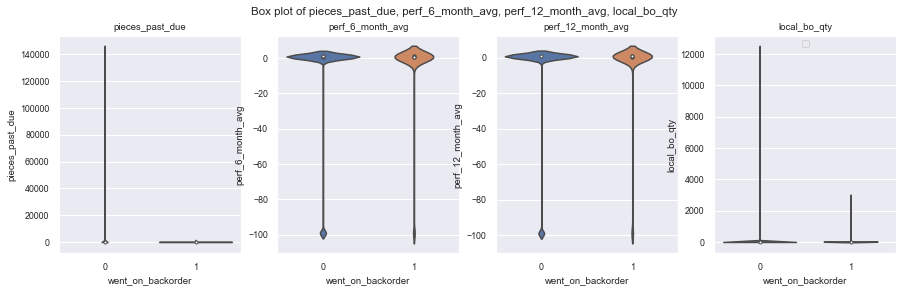

In [303]:
# plot violin plot for each sensor on max change
title = 'Box plot of pieces_past_due, perf_6_month_avg, perf_12_month_avg, local_bo_qty'
bivariate_plot(project_data[col], title, 4)

In [304]:
for j in col[:-1]:
    print('=='*21)
    print('{} column '.format(j))
    
    x = PrettyTable()
    x.field_names = ["Percentile", "BackOrder", "Non_Backorder"]
    bck1 = project_data[project_data['went_on_backorder']==1][j].values
    bck2 = project_data[project_data['went_on_backorder']==0][j].values
    for i in range(0,11,1):
        x.add_row([(i*0.1)+99,np.round(np.percentile(bck1,(i*0.1)+99), 3), np.round(np.percentile(bck2,(i*0.1)+99), 3)])
    print(x)


pieces_past_due column 
+------------+-----------+---------------+
| Percentile | BackOrder | Non_Backorder |
+------------+-----------+---------------+
|    99.0    |    72.0   |      4.0      |
|    99.1    |    80.0   |      5.0      |
|    99.2    |    84.0   |      8.0      |
|    99.3    |    90.0   |      11.0     |
|    99.4    |   100.0   |      16.0     |
|    99.5    |   120.0   |      23.0     |
|    99.6    |  149.328  |      34.0     |
|    99.7    |   200.0   |      54.0     |
|    99.8    |  258.392  |     100.0     |
|    99.9    |   600.0   |     235.0     |
|   100.0    |   1488.0  |    146496.0   |
+------------+-----------+---------------+
perf_6_month_avg column 
+------------+-----------+---------------+
| Percentile | BackOrder | Non_Backorder |
+------------+-----------+---------------+
|    99.0    |    1.0    |      1.0      |
|    99.1    |    1.0    |      1.0      |
|    99.2    |    1.0    |      1.0      |
|    99.3    |    1.0    |      1.0      |
|    

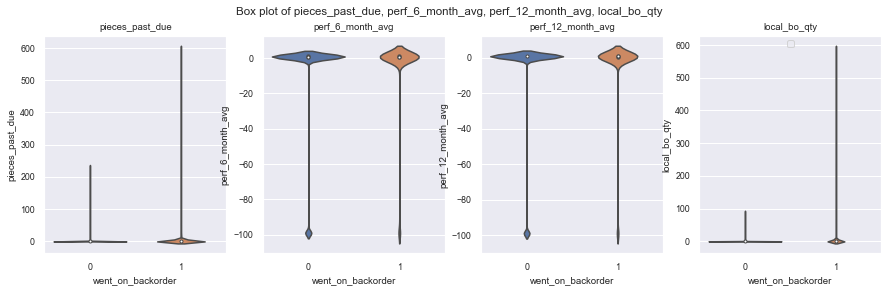

In [307]:
temp = project_data[((project_data['went_on_backorder']==1) & (project_data['pieces_past_due'] <=600) & (project_data['local_bo_qty'] <=791)) | ((project_data['went_on_backorder']==0) & (project_data['pieces_past_due'] <=236) & (project_data['local_bo_qty'] <=93))]

# plot violin plot for each sensor on max change
title = 'Box plot of pieces_past_due, perf_6_month_avg, perf_12_month_avg, local_bo_qty'

bivariate_plot(temp[col], title, 4)

### deck_risk, oe_constraint, ppap_risk, stop_auto_buy, rev_stop

In [308]:
col = ['deck_risk', 'oe_constraint', 'ppap_risk', 'stop_auto_buy', 'rev_stop']

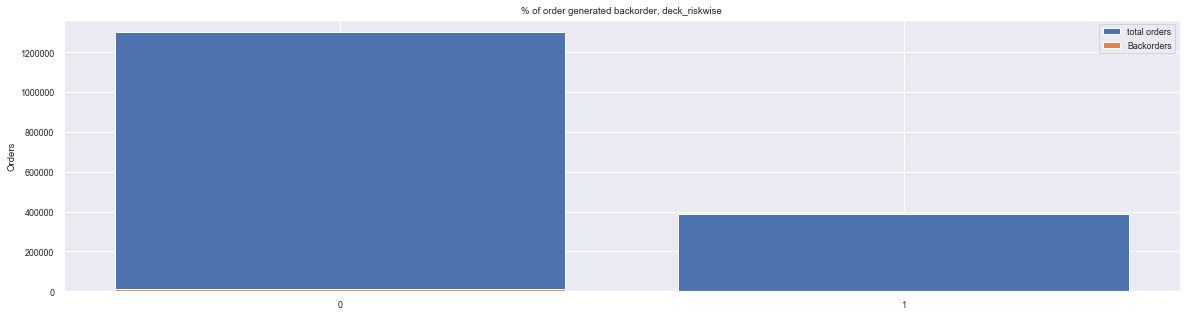

   deck_risk  went_on_backorder    total       Avg
0          0               9377  1300377  0.007211
1          1               1916   387483  0.004945


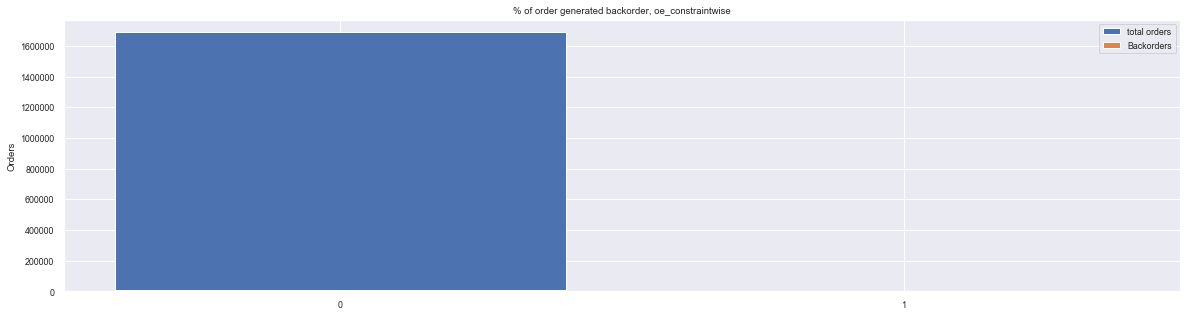

   oe_constraint  went_on_backorder    total       Avg
0              0              11285  1687615  0.006687
1              1                  8      245  0.032653


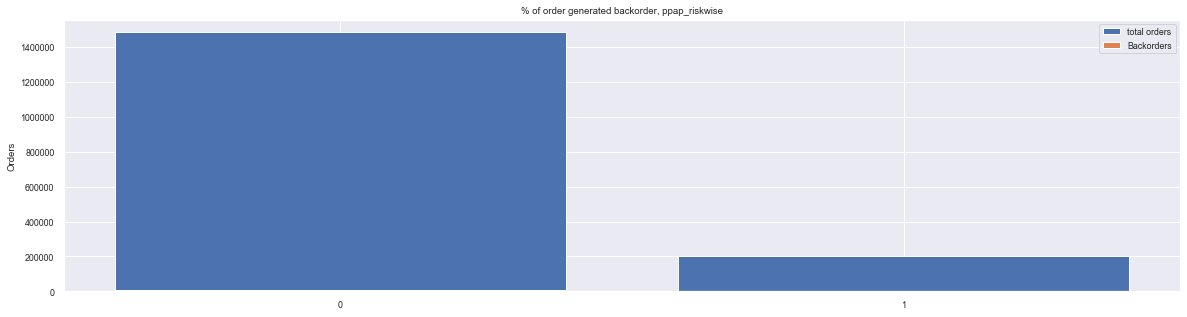

   ppap_risk  went_on_backorder    total       Avg
0          0               9534  1484026  0.006424
1          1               1759   203834  0.008630


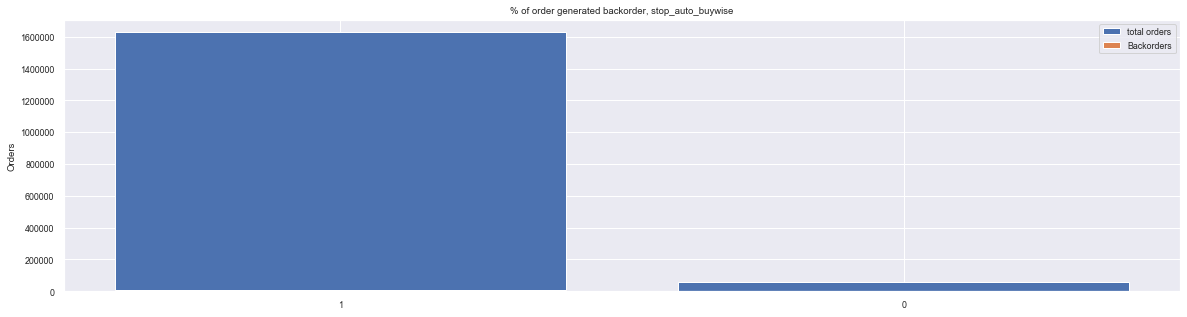

   stop_auto_buy  went_on_backorder    total       Avg
1              1              10822  1626774  0.006652
0              0                471    61086  0.007710


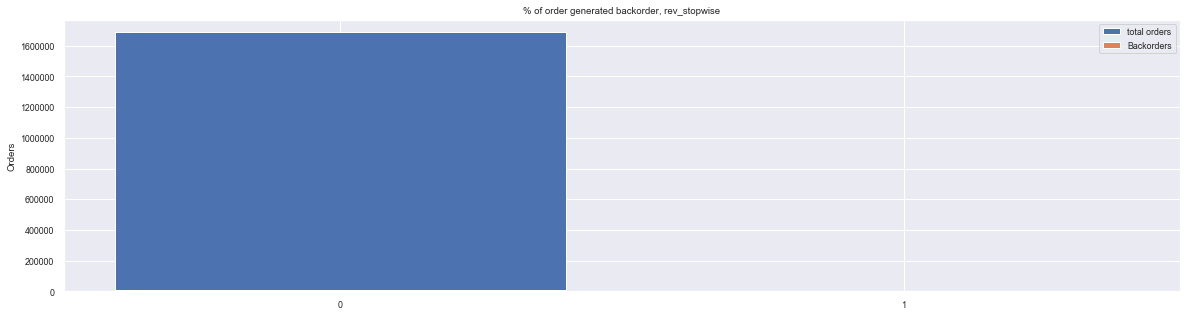

   rev_stop  went_on_backorder    total       Avg
0         0              11293  1687129  0.006694
1         1                  0      731  0.000000


In [309]:
for i in col:
    title = '% of order generated backorder, '+ i + 'wise'
    univariate_barplots(project_data, title, i, 'went_on_backorder', False)

In [333]:
project_data[project_data['rev_stop']==1]['went_on_backorder'].value_counts()

0    731
Name: went_on_backorder, dtype: int64

### Pairplots

In [354]:
#col_floatType = [i for i in project_data.columns if (project_data[i].dtype == np.float64) and (i not in ['sku']) ]

In [388]:
col_floatType = ['lead_time','in_transit_qty','min_bank','pieces_past_due','perf_6_month_avg','perf_12_month_avg']

In [384]:
temp1 = project_data[project_data['went_on_backorder']==0].sample(frac= 0.005, random_state=1)
temp2 = project_data[project_data['went_on_backorder']==1].sample(frac= 0.01, random_state=1)
sample_data = pd.concat([temp1, temp2])

In [385]:
sample_data.head()

sku  national_inv  lead_time  in_transit_qty  forecast_3_month  \
763707   2111654           3.0        2.0             0.0               0.0   
1476847  3068017          12.0        8.0             0.0               0.0   
354709   1702660          12.0        8.0             0.0               0.0   
827907   2175875         402.0        2.0             0.0               0.0   
542833   1890791         523.0        8.0             0.0               0.0   

         forecast_6_month  forecast_9_month  sales_1_month  sales_3_month  \
763707                0.0               0.0            0.0            0.0   
1476847               0.0               0.0            0.0            0.0   
354709                0.0               0.0            0.0            2.0   
827907                0.0               0.0            0.0            0.0   
542833                0.0               0.0           14.0           44.0   

         sales_6_month  sales_9_month  min_bank  potential_issue  \
763707             0.0            0.0       1.0                0   
1476847            0.0            0.0       0.0                0   
354709             9.0           22.0       1.0                0   
827907             0.0            0.0       0.0                0   
542833            89.0          118.0      19.0                0   

         pieces_past_due  perf_6_month_avg  perf_12_month_avg  local_bo_qty  \
763707               0.0              0.88               0.91           0.0   
1476847              0.0              0.74               0.71           0.0   
354709               0.0              0.85               0.90           0.0   
827907               0.0              0.82               0.81           0.0   
542833               0.0              0.86               0.80           0.0   

         deck_risk  oe_constraint  ppap_risk  stop_auto_buy  rev_stop  \
763707           0              0          0              1         0   
1476847          0              0          1              1         0   
354709           0              0          0              1         0   
827907           0              0          0              1         0   
542833           0              0          0              1         0   

         went_on_backorder  
763707                   0  
1476847                  0  
354709                   0  
827907                   0  
542833                   0

In [386]:
sample_data.shape

(8496, 23)

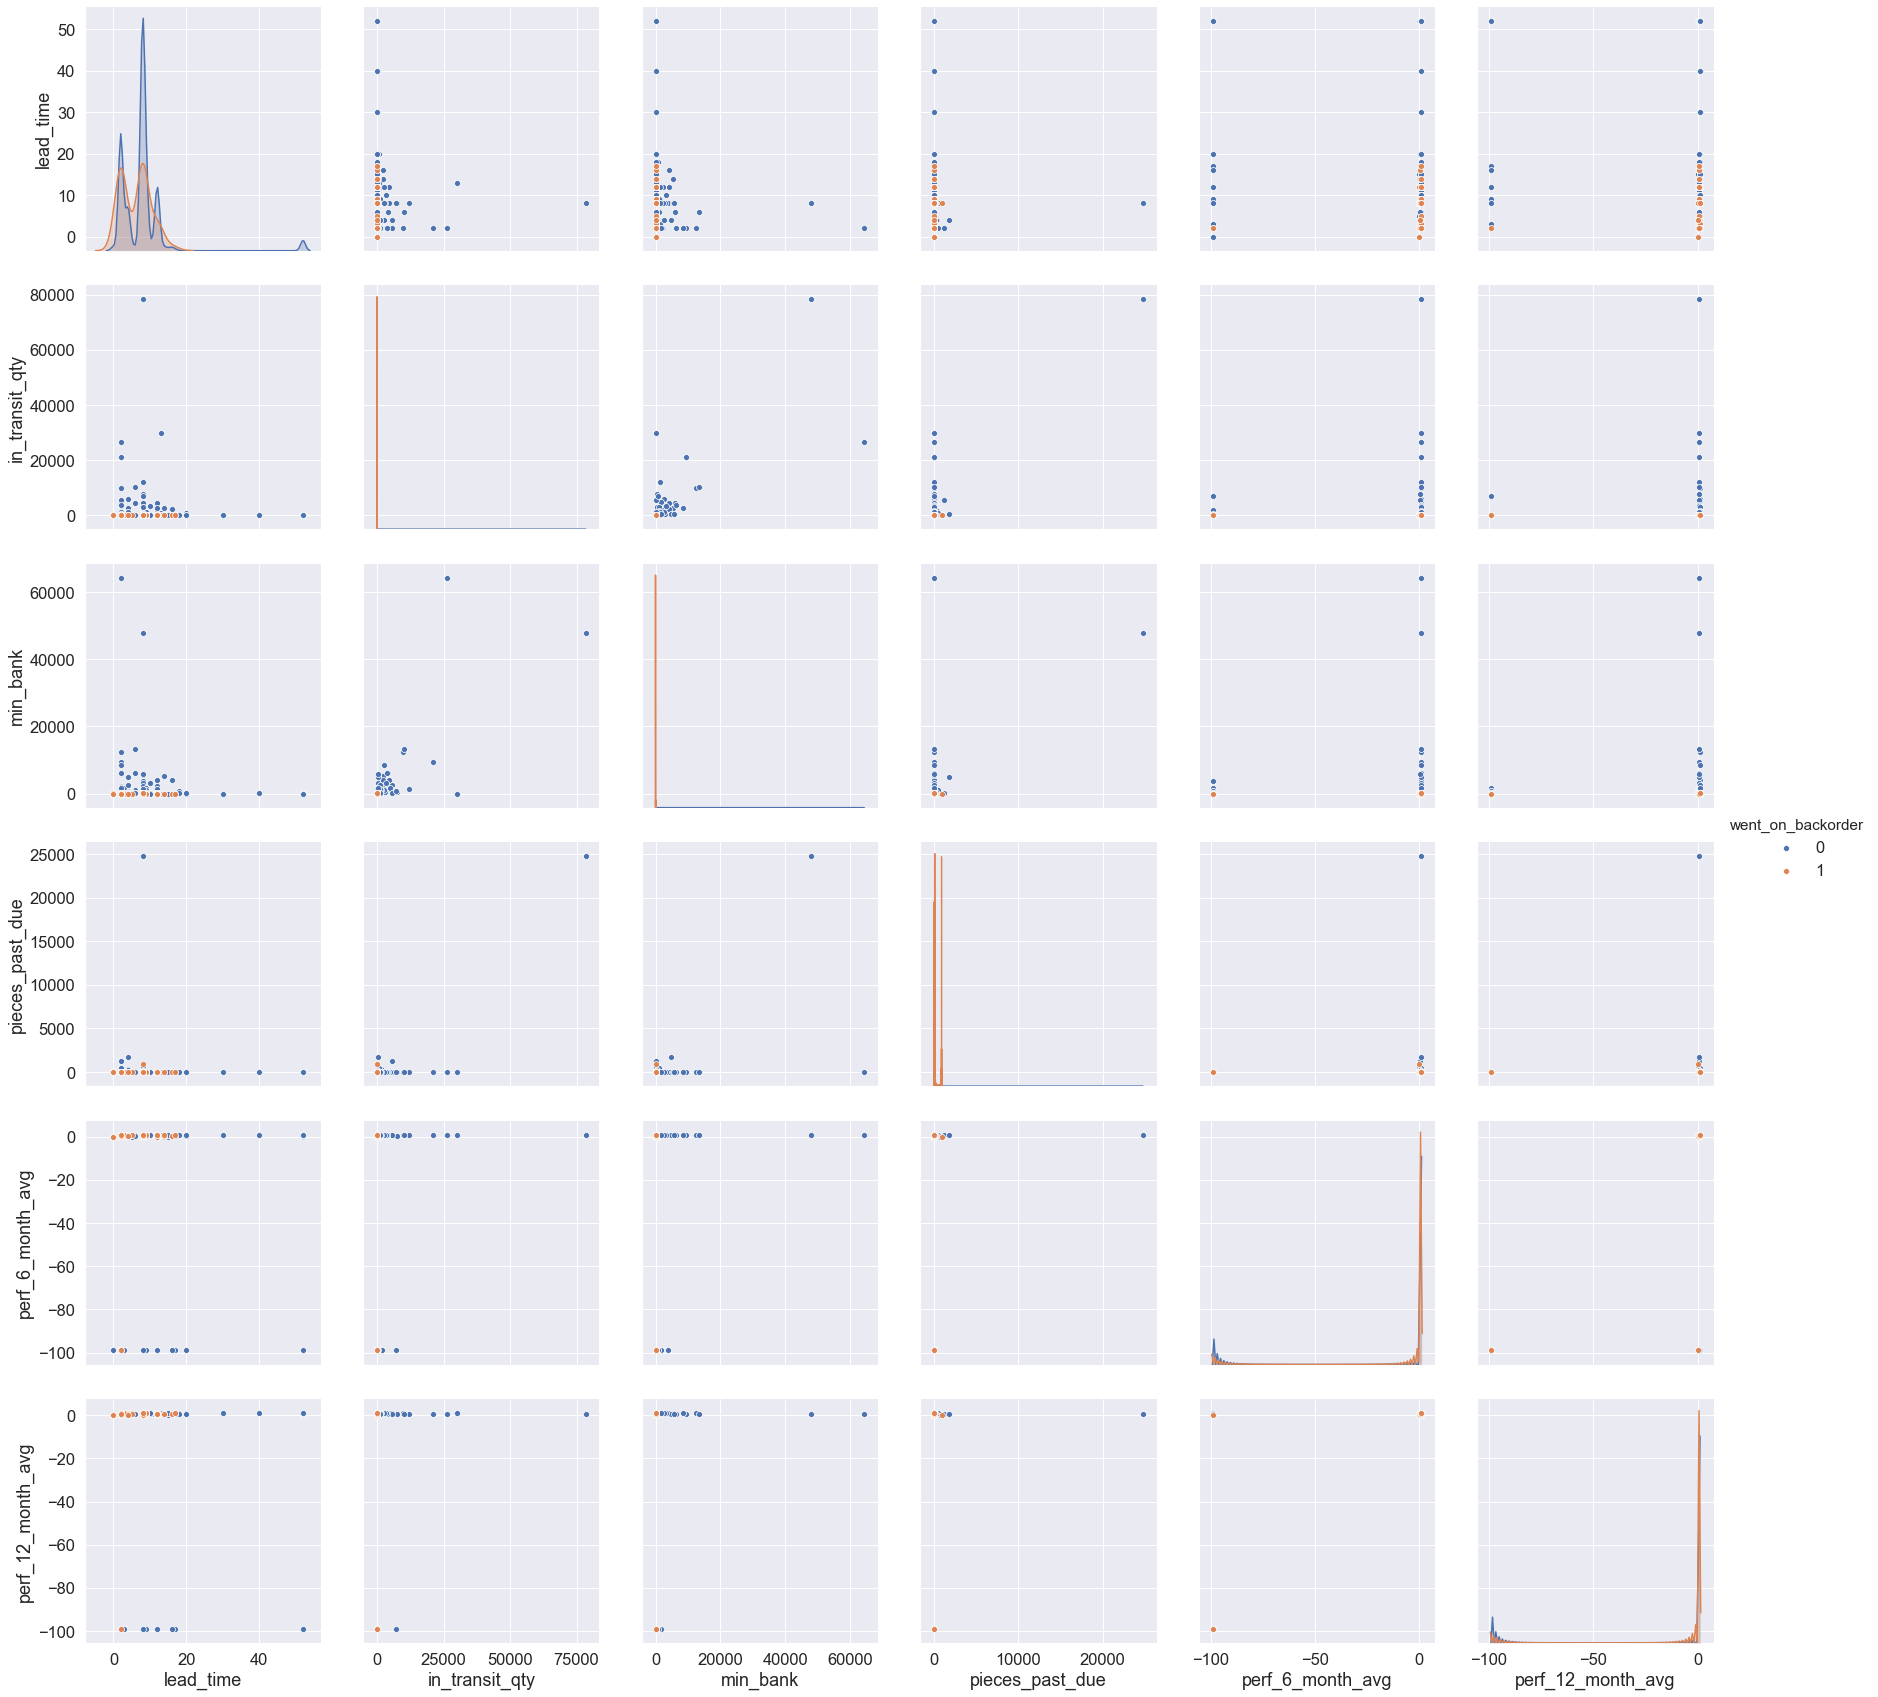

In [390]:
# Pair plot for all selected features
temp = sample_data[col_floatType]
temp['went_on_backorder'] = sample_data.iloc[:,-1]

sns.set_style("whitegrid");
sns.set(font_scale = 1.5)
sns.pairplot(temp, hue='went_on_backorder', size=4, vars=col_floatType);
plt.show()

### Lead time missing value imputation

In [10]:
project_data['lead_time'].isnull().sum()

100893

In [11]:
# Ignore sku and went_on_backorder columns

col = project_data.columns.values[1:-1]
col = [i for i in col if i != 'lead_time']

In [12]:
from sklearn.neighbors import KNeighborsRegressor

temp = project_data.dropna()
X_lt = temp[col]
y_lt = temp['lead_time']

knn_model = KNeighborsRegressor(n_neighbors = 5, weights = 'uniform', metric = 'euclidean', algorithm = 'kd_tree')
knn_model.fit(X_lt, y_lt)

KNeighborsRegressor(algorithm='kd_tree', leaf_size=30, metric='euclidean',
                    metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                    weights='uniform')

In [13]:
len(col)

20

In [14]:
def impute_missing_lt (row):
    if pd.isnull(row['lead_time']) :
        return knn_model.predict(row[col].values.reshape((-1, 20)))[0]  # 20 is bacause total 20 columns after removing sku, 
                                                                     # lead_time and went_on_backorder
    else:
        return row['lead_time']
    
project_data["lead_time_KNN_Imputed"] = project_data.apply(impute_missing_lt,axis=1)

In [15]:
import pickle as pkl
# save all dataset

knn_impute_data = [project_data]
with open("knn_impute_data.pkl", "wb") as f:
    pkl.dump(knn_impute_data, f)

In [16]:
project_data.head()

sku  national_inv  lead_time  in_transit_qty  forecast_3_month  \
0  1026827           0.0        NaN             0.0               0.0   
1  1043384           2.0        9.0             0.0               0.0   
2  1043696           2.0        NaN             0.0               0.0   
3  1043852           7.0        8.0             0.0               0.0   
4  1044048           8.0        NaN             0.0               0.0   

   forecast_6_month  forecast_9_month  sales_1_month  sales_3_month  \
0               0.0               0.0            0.0            0.0   
1               0.0               0.0            0.0            0.0   
2               0.0               0.0            0.0            0.0   
3               0.0               0.0            0.0            0.0   
4               0.0               0.0            0.0            0.0   

   sales_6_month  sales_9_month  min_bank  potential_issue  pieces_past_due  \
0            0.0            0.0       0.0                0              0.0   
1            0.0            0.0       0.0                0              0.0   
2            0.0            0.0       0.0                0              0.0   
3            0.0            0.0       1.0                0              0.0   
4            0.0            4.0       2.0                0              0.0   

   perf_6_month_avg  perf_12_month_avg  local_bo_qty  deck_risk  \
0            -99.00             -99.00           0.0          0   
1              0.99               0.99           0.0          0   
2            -99.00             -99.00           0.0          1   
3              0.10               0.13           0.0          0   
4            -99.00             -99.00           0.0          1   

   oe_constraint  ppap_risk  stop_auto_buy  rev_stop  went_on_backorder  \
0              0          0              1         0                  0   
1              0          0              1         0                  0   
2              0          0              1         0                  0   
3              0          0              1         0                  0   
4              0          0              1         0                  0   

   lead_time_KNN_Imputed  
0                    6.4  
1                    9.0  
2                    4.0  
3                    8.0  
4                   16.8

## correlation

In [450]:
col = [i for i in project_data.columns if i not in ['sku','lead_time']]

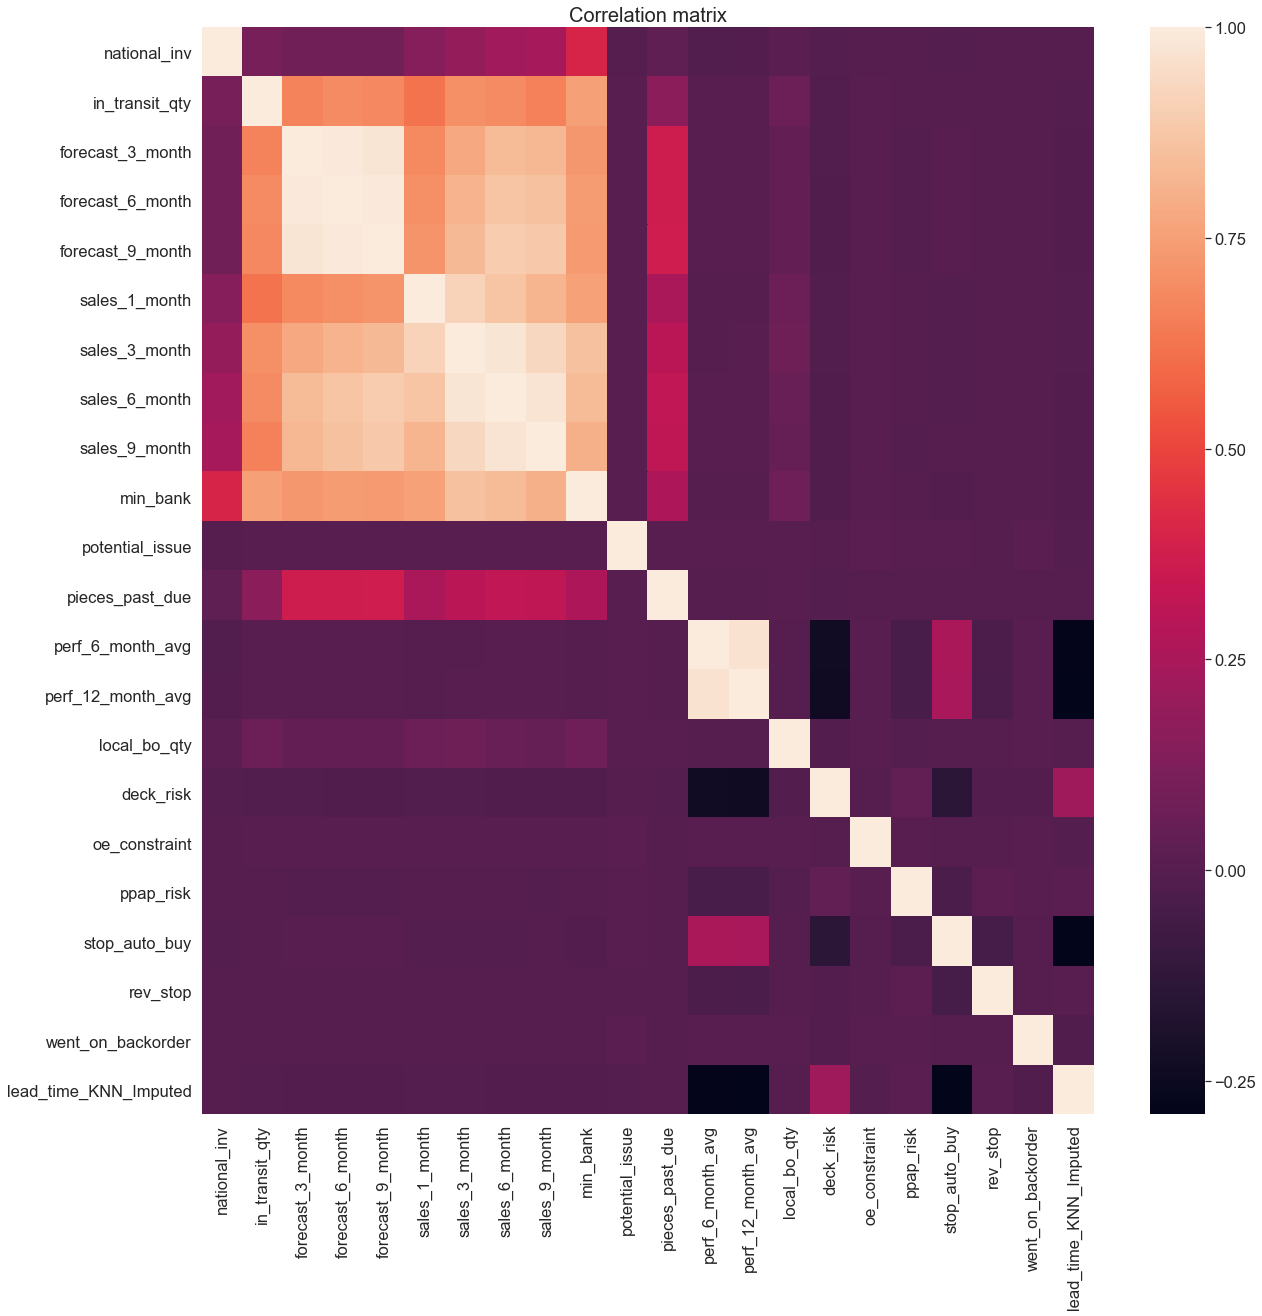

In [451]:
corr= project_data[col].corr()
plt.figure(figsize=(20,20))

sns.heatmap(corr)
plt.title('Correlation matrix', fontsize=20)
plt.show()

### Preprocessing

In [36]:
# Creating correlation matrix
cor_matrix = project_data[col].corr().abs()

# Selecting upper triangle of correlation matrix
upper_tri = cor_matrix.where(np.triu(np.ones(cor_matrix.shape),
                                  k=1).astype(np.bool))

# Finding index of feature columns with correlation greater than 0.95
to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > 0.95)]

# Droping Marked Features
df = project_data.drop(project_data[to_drop], axis=1)

In [17]:
#df = project_data

In [454]:
df.shape

(1687860, 19)

In [456]:
df.head()

sku  national_inv  lead_time  in_transit_qty  forecast_3_month  \
0  1026827           0.0        NaN             0.0               0.0   
1  1043384           2.0        9.0             0.0               0.0   
2  1043696           2.0        NaN             0.0               0.0   
3  1043852           7.0        8.0             0.0               0.0   
4  1044048           8.0        NaN             0.0               0.0   

   sales_1_month  sales_3_month  min_bank  potential_issue  pieces_past_due  \
0            0.0            0.0       0.0                0              0.0   
1            0.0            0.0       0.0                0              0.0   
2            0.0            0.0       0.0                0              0.0   
3            0.0            0.0       1.0                0              0.0   
4            0.0            0.0       2.0                0              0.0   

   perf_6_month_avg  local_bo_qty  deck_risk  oe_constraint  ppap_risk  \
0            -99.00           0.0          0              0          0   
1              0.99           0.0          0              0          0   
2            -99.00           0.0          1              0          0   
3              0.10           0.0          0              0          0   
4            -99.00           0.0          1              0          0   

   stop_auto_buy  rev_stop  went_on_backorder  lead_time_KNN_Imputed  
0              1         0                  0                    6.4  
1              1         0                  0                    9.0  
2              1         0                  0                    4.0  
3              1         0                  0                    8.0  
4              1         0                  0                   16.8

In [457]:
# Check if any features has a constant value
temp = df.nunique().reset_index()
temp.columns = ['column','unique_values']
temp[temp.unique_values == 1]

Empty DataFrame
Columns: [column, unique_values]
Index: []

In [37]:
# drop sku and lead time column
df1 = df.drop(['sku','lead_time'], axis = 1)

# drop national_inv rows
df1 = df1[((df1['went_on_backorder']==1) & (df1['national_inv']<2065)) | ((df1['went_on_backorder']==0) & (df1['national_inv']<41656))]

# drop intransit qty
df1 = df1[((df1['went_on_backorder']==1) & (df1['in_transit_qty']<707)) | ((df1['went_on_backorder']==0) & (df1['in_transit_qty']<5589))]

# drop forecast 3 month rows 
df1 = df1[((df1['went_on_backorder']==1) & (df1['forecast_3_month'] <=15000)) | ((df1['went_on_backorder']==0) & (df1['forecast_3_month'] <=21567))]

# drop sales 1 and 3 month rows
df1 = df1[((df1['went_on_backorder']==1) & (df1['sales_1_month'] <=2819) & (df1['sales_3_month'] <=9040)) | ((df1['went_on_backorder']==0) & (df1['sales_1_month'] <=5842) & (df1['sales_3_month'] <=18169))]

# drop min bank rows
df1 = df1[((df1['went_on_backorder']==1) & (df1['min_bank']<2232)) | ((df1['went_on_backorder']==0) & (df1['min_bank']<5657))]

# drop local_bo_qty and pieces_past_due
df1 = df1[((df1['went_on_backorder']==1) & (df1['pieces_past_due'] <=600) & (df1['local_bo_qty'] <=791)) | ((df1['went_on_backorder']==0) & (df1['pieces_past_due'] <=236) & (df1['local_bo_qty'] <=93))]

In [38]:
print('Total droped rows : ',df.shape[0]- df1.shape[0])

Total droped rows :  7250


In [39]:
print('Total data count afetr preprocess : ', df1.shape[0])

Total data count afetr preprocess :  1680610


In [101]:
df1.head()

national_inv  in_transit_qty  forecast_3_month  sales_1_month  \
0           0.0             0.0               0.0            0.0   
1           2.0             0.0               0.0            0.0   
2           2.0             0.0               0.0            0.0   
3           7.0             0.0               0.0            0.0   
4           8.0             0.0               0.0            0.0   

   sales_3_month  min_bank  potential_issue  pieces_past_due  \
0            0.0       0.0                0              0.0   
1            0.0       0.0                0              0.0   
2            0.0       0.0                0              0.0   
3            0.0       1.0                0              0.0   
4            0.0       2.0                0              0.0   

   perf_6_month_avg  local_bo_qty  deck_risk  oe_constraint  ppap_risk  \
0            -99.00           0.0          0              0          0   
1              0.99           0.0          0              0          0   
2            -99.00           0.0          1              0          0   
3              0.10           0.0          0              0          0   
4            -99.00           0.0          1              0          0   

   stop_auto_buy  rev_stop  went_on_backorder  lead_time_KNN_Imputed  
0              1         0                  0                    6.4  
1              1         0                  0                    9.0  
2              1         0                  0                    4.0  
3              1         0                  0                    8.0  
4              1         0                  0                   16.8

In [102]:
df1['went_on_backorder'].value_counts()

0    1669369
1      11241
Name: went_on_backorder, dtype: int64

### Modeling

In [40]:
col = [i for i in df1.columns if i not in 'went_on_backorder']
X = df1[col]
y = df1['went_on_backorder']

In [41]:
# split the data into test and train by maintaining same distribution of output varaible
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3)
X_train, X_cv, y_train, y_cv = train_test_split(X_train, y_train, stratify=y_train, test_size=0.15)

In [42]:
print('Total data points in train data: {}, |  class 0 data points: {}, |  class 1 data points: {}' 
      .format(X_train.shape[0], y_train.value_counts()[0], y_train.value_counts()[1]))
print('Total data points in cv data: {},     |  class 0 data points: {},  |  class 1 data points: {}' 
      .format(X_cv.shape[0], y_cv.value_counts()[0], y_cv.value_counts()[1]))
print('Total data points in test data: {},  |  class 0 data points: {}, |  class 1 data points: {}' 
      .format(X_test.shape[0], y_test.value_counts()[0], y_test.value_counts()[1]))

Total data points in train data: 999962, |  class 0 data points: 993273, |  class 1 data points: 6689
Total data points in cv data: 176465,     |  class 0 data points: 175285,  |  class 1 data points: 1180
Total data points in test data: 504183,  |  class 0 data points: 500811, |  class 1 data points: 3372


### Lets perform oversampling using SMOTE and undersampling of majority class.

In [43]:
# Here we will use SMOTE which will help us perform oversampling of minority class and undersmapling
# of majority class together.
from imblearn.under_sampling import NearMiss
from imblearn.pipeline import make_pipeline
from imblearn.over_sampling import SMOTE

pipe = make_pipeline(SMOTE(sampling_strategy=0.1), NearMiss(sampling_strategy=0.1))
X_train_osus, y_train_osus = pipe.fit_resample(X_train, y_train)
print('After SMOTE oversampling with undersampling:')
print('Total data points in train data: {}, |  class 0 data points: {}, |  class 1 data points: {}'
      .format(X_train_osus.shape[0], y_train_osus.value_counts()[0], y_train_osus.value_counts()[1]))

After SMOTE oversampling with undersampling:
Total data points in train data: 1092597, |  class 0 data points: 993270, |  class 1 data points: 99327


In [44]:
pipe1 = make_pipeline(SMOTE(sampling_strategy=0.1), NearMiss(sampling_strategy=0.3))
X_train_osus1, y_train_osus1 = pipe1.fit_resample(X_train, y_train)
print('After SMOTE oversampling with undersampling:')
print('Total data points in train data: {}, |  class 0 data points: {}, |  class 1 data points: {}'
      .format(X_train_osus1.shape[0], y_train_osus1.value_counts()[0], y_train_osus1.value_counts()[1]))

After SMOTE oversampling with undersampling:
Total data points in train data: 430417, |  class 0 data points: 331090, |  class 1 data points: 99327


In [27]:
X_train.shape

(999962, 21)

In [28]:
X_train_osus.shape

(1092597, 21)

In [52]:
import pickle as pkl
# save all dataset

all_data = [X_train_osus, y_train_osus, X_train, y_train, X_cv, y_cv, X_test, y_test]
with open("all_data_set.pkl", "wb") as f:
    pkl.dump(all_data, f)

In [3]:
import pickle as pkl
pickle_in = open("all_data_set.pkl","rb")
X_train_osus, y_train_osus, X_train, y_train, X_cv, y_cv, X_test, y_test = pkl.load(pickle_in)

### Logistic regression

In [45]:
def logistic_reg(train_df, X_cv, y_cv, X_test, y_test):
    ''' This function will take train, test and cv data and perform logoctoc regression on train data and return 
    prediction of all train, cv and test data for best alpha value using grid search'''
    
    X_train = train_df[0]
    y_train = train_df[1]
    alpha = [10 ** x for x in range(-5, 4)]
    cv_error_array=[]
    for i in alpha:
        logisticR=LogisticRegression(penalty='l2',C=i, random_state =32)
        logisticR.fit(X_train,y_train)
        predict_y = logisticR.predict(X_cv)
        cv_error_array.append(f1_score(y_cv, predict_y))

    best_alpha = np.argmax(cv_error_array)

    logisticR=LogisticRegression(penalty='l2',C=alpha[best_alpha], random_state =32)
    logisticR.fit(X_train,y_train)
    
    predict_y_train = logisticR.predict(X_train)
    f1_train = f1_score(y_train, predict_y_train)
    predict_y_cv = logisticR.predict(X_cv)
    f1_cv = f1_score(y_cv, predict_y_cv)
    predict_y_test = logisticR.predict(X_test)
    f1_test = f1_score(y_test, predict_y_test)

    return logisticR, alpha, alpha[best_alpha], f1_train, f1_cv, f1_test, cv_error_array, predict_y_test

In [46]:
summary = []

print("="*127)
train_df = [X_train_osus, y_train_osus]
clf_lr, alpha, best_alpha, f1_train, f1_cv, f1_test, error, predict_y_test = logistic_reg(train_df, X_cv, y_cv, X_test, y_test)
    
temp = ['Log_reg',best_alpha,f1_train, f1_cv, f1_test]
summary.append(temp)

print (tabulate(summary,headers=['Model','Best alpha', 'Train f1 score',
                                 'CV f1 score','Test f1 score'], tablefmt='orgtbl'))
print("="*127)

| Model   |   Best alpha |   Train f1 score |   CV f1 score |   Test f1 score |
|---------+--------------+------------------+---------------+-----------------|
| Log_reg |       0.0001 |         0.144318 |      0.116772 |       0.0988349 |


Text(0.5, 34.43999999999998, 'Pred')

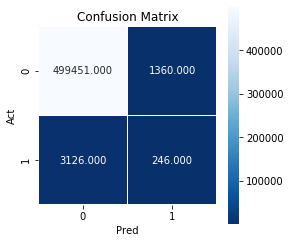

In [47]:
plt.figure(figsize=(4,4))
conf_mat = confusion_matrix(y_true=y_test, y_pred=predict_y_test)
sns.heatmap(conf_mat, annot=True,fmt=".3f", linewidths=.5, square=True, cmap='Blues_r')
plt.title('Confusion Matrix')
plt.ylabel('Act')
plt.xlabel('Pred')

In [48]:
print("="*127)
train_df = [X_train_osus1, y_train_osus1]
clf_lr1, alpha1, best_alpha1, f1_train1, f1_cv1, f1_test1, error1, predict_y_test1 = logistic_reg(train_df, X_cv, y_cv, X_test, y_test)

In [49]:
f1_train1, f1_cv1, f1_test1

(0.740602727831844, 0.031311799604482535, 0.029892479317402208)

### Random Forest

In [50]:
def random_forest(train_df, X_cv, y_cv, X_test, y_test):
    ''' This function will take train, test and cv data and perform random forest classifier on train data and return 
    prediction of all train, cv and test data for best alpha value using grid search'''
    
    X_train = train_df[0]
    y_train = train_df[1]
    alpha=[10,20,50,100,200]
    cv_error_array=[]
    for i in alpha:
        rf = RandomForestClassifier(n_estimators=i,random_state=32,n_jobs=-1)
        rf.fit(X_train,y_train)
        predict_y = rf.predict(X_cv)
        cv_error_array.append(f1_score(y_cv, predict_y))

    best_alpha = np.argmax(cv_error_array)

    rf = RandomForestClassifier(n_estimators=alpha[best_alpha],random_state=32,n_jobs=-1)
    rf.fit(X_train,y_train)
    
    predict_y_train = rf.predict(X_train)
    f1_train = f1_score(y_train, predict_y_train)
    predict_y_cv = rf.predict(X_cv)
    f1_cv = f1_score(y_cv, predict_y_cv)
    predict_y_test = rf.predict(X_test)
    f1_test = f1_score(y_test, predict_y_test)

    return rf, alpha, alpha[best_alpha], f1_train, f1_cv, f1_test, cv_error_array, predict_y_test

In [51]:
print("="*127)
train_df = [X_train_osus, y_train_osus]
clf_rf, alpha, best_alpha, f1_train, f1_cv, f1_test, error, predict_y_test = random_forest(train_df, X_cv, y_cv, X_test, y_test)
    
temp = ['Random_Forest',best_alpha,f1_train, f1_cv, f1_test]
summary.append(temp)

print (tabulate(summary,headers=['Model','Best alpha', 'Train f1 score',
                                 'CV f1 score','Test f1 score'], tablefmt='orgtbl'))
print("="*127)

| Model         |   Best alpha |   Train f1 score |   CV f1 score |   Test f1 score |
|---------------+--------------+------------------+---------------+-----------------|
| Log_reg       |       0.0001 |         0.144318 |      0.116772 |       0.0988349 |
| Random_Forest |     200      |         0.987209 |      0.384909 |       0.392328  |


Text(0.5, 34.43999999999998, 'Pred')

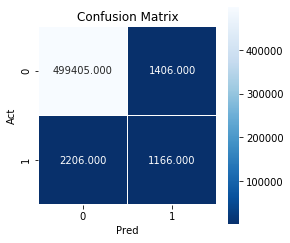

In [53]:
plt.figure(figsize=(4,4))
conf_mat = confusion_matrix(y_true=y_test, y_pred=predict_y_test)
sns.heatmap(conf_mat, annot=True,fmt=".3f", linewidths=.5, square=True, cmap='Blues_r')
plt.title('Confusion Matrix')
plt.ylabel('Act')
plt.xlabel('Pred')

### XGBoost

In [57]:
def xgboost(train_df, X_cv, y_cv, X_test, y_test):
    ''' This function will take train, test and cv data and perform XgBoost classifier on train data and return 
    prediction of all train, cv and test data for best alpha value using grid search'''
    
    X_train = train_df[0]
    y_train = train_df[1]
    alpha=[20,50,100,200]
    cv_error_array=[]
    for i in alpha:
        xgb = XGBClassifier(n_estimators=i,nthread=-1,random_state = 32)
        xgb.fit(X_train,y_train)
        predict_y = xgb.predict(X_cv)
        cv_error_array.append(f1_score(y_cv, predict_y))

    best_alpha = np.argmax(cv_error_array)

    xgb = XGBClassifier(n_estimators=alpha[best_alpha],nthread=-1,random_state = 32)
    xgb.fit(X_train,y_train)
    
    predict_y_train = xgb.predict(X_train)
    f1_train = f1_score(y_train, predict_y_train)
    predict_y_cv = xgb.predict(X_cv)
    f1_cv = f1_score(y_cv, predict_y_cv)
    predict_y_test = xgb.predict(X_test)
    f1_test = f1_score(y_test, predict_y_test)

    return xgb, alpha, alpha[best_alpha], f1_train, f1_cv, f1_test, cv_error_array, predict_y_test

In [58]:


print("="*127)
train_df = [X_train_osus, y_train_osus]
clf_xg, alpha, best_alpha, f1_train, f1_cv, f1_test, error, predict_y_test = xgboost(train_df, X_cv, y_cv, X_test, y_test)
    
temp = ['XgBoost',best_alpha,f1_train, f1_cv, f1_test]
summary.append(temp)

print (tabulate(summary,headers=['Model','Best alpha', 'Train f1 score',
                                 'CV f1 score','Test f1 score'], tablefmt='orgtbl'))
print("="*127)

| Model         |   Best alpha |   Train f1 score |   CV f1 score |   Test f1 score |
|---------------+--------------+------------------+---------------+-----------------|
| Log_reg       |       0.0001 |         0.144318 |      0.116772 |       0.0988349 |
| Random_Forest |     200      |         0.987209 |      0.384909 |       0.392328  |
| XgBoost       |      20      |         0.784316 |      0.276564 |       0.265313  |


## ANN model

In [5]:
import tensorflow
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential

In [6]:
len(X_train.columns)

16

In [8]:
input_size = 16

In [10]:
model = Sequential()
model.add(Dense(50,input_dim= input_size, activation='relu', kernel_initializer='he_uniform'))
#model.add(Dense(25, activations='relu', kernel_initializer='he_uniform'))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',optimizer='adam')
model.fit(X_train_osus,y_train_osus,epochs= 10)

Epoch 1/10
34144/34144 [==============================] - 81s 2ms/step - loss: 0.3158
Epoch 2/10
34144/34144 [==============================] - 91s 3ms/step - loss: 0.2027
Epoch 3/10
34144/34144 [==============================] - 81s 2ms/step - loss: 0.1678
Epoch 4/10
34144/34144 [==============================] - 80s 2ms/step - loss: 0.1544
Epoch 5/10
34144/34144 [==============================] - 79s 2ms/step - loss: 0.1516
Epoch 6/10
34144/34144 [==============================] - 69s 2ms/step - loss: 0.1502
Epoch 7/10
34144/34144 [==============================] - 63s 2ms/step - loss: 0.1493
Epoch 8/10
34144/34144 [==============================] - 82s 2ms/step - loss: 0.1481
Epoch 9/10
34144/34144 [==============================] - 79s 2ms/step - loss: 0.1472
Epoch 10/10
34144/34144 [==============================] - 81s 2ms/step - loss: 0.1467


In [18]:
y_test_pred[0]

array([0.06206551], dtype=float32)

In [17]:
from sklearn.metrics import roc_auc_score
y_test_pred = model.predict(X_test)

roc_auc_score = roc_auc_score(y_test, y_test_pred)
print(f"test roc_auc_score :" , roc_auc_score)

test roc_auc_score : 0.9370750230907201


In [28]:
y_test_pred_cl = [1 if i>0.5 else 0 for i in y_test_pred ]

In [29]:
f1_score = f1_score(y_test, y_test_pred_cl)
print(f"test f1_score :" , f1_score)

test f1_score : 0.2074284776543953


Text(0.5, 34.43999999999998, 'Pred')

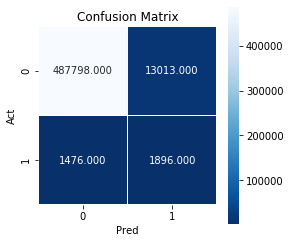

In [30]:
plt.figure(figsize=(4,4))
conf_mat = confusion_matrix(y_true=y_test, y_pred=y_test_pred_cl)
sns.heatmap(conf_mat, annot=True,fmt=".3f", linewidths=.5, square=True, cmap='Blues_r')
plt.title('Confusion Matrix')
plt.ylabel('Act')
plt.xlabel('Pred')

In [37]:
weights = {0:1,1:140}
model = Sequential()
model.add(Dense(50,input_dim= input_size, activation='relu', kernel_initializer='he_uniform'))
model.add(Dense(25, activation='relu', kernel_initializer='he_uniform'))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',optimizer='adam')
model.fit(X_train,y_train,class_weight=weights, epochs= 10)

Epoch 1/10
31249/31249 [==============================] - 68s 2ms/step - loss: 3.3507
Epoch 2/10
31249/31249 [==============================] - 66s 2ms/step - loss: 1.0999
Epoch 3/10
31249/31249 [==============================] - 64s 2ms/step - loss: 0.7388
Epoch 4/10
31249/31249 [==============================] - 70s 2ms/step - loss: 0.8042
Epoch 5/10
31249/31249 [==============================] - 68s 2ms/step - loss: 0.7491
Epoch 6/10
31249/31249 [==============================] - ETA: 0s - loss: 0.730 - 70s 2ms/step - loss: 0.7307
Epoch 7/10
31249/31249 [==============================] - 70s 2ms/step - loss: 0.7155
Epoch 8/10
31249/31249 [==============================] - 68s 2ms/step - loss: 0.7612
Epoch 9/10
31249/31249 [==============================] - 73s 2ms/step - loss: 0.6813
Epoch 10/10
31249/31249 [==============================] - 73s 2ms/step - loss: 0.8180


In [38]:
from sklearn.metrics import roc_auc_score
y_test_pred = model.predict(X_test)

roc_auc_score = roc_auc_score(y_test, y_test_pred)
print(f"test roc_auc_score :" , roc_auc_score)

test roc_auc_score : 0.9290080501881465


In [40]:
from sklearn.metrics import f1_score
y_test_pred_cl = [1 if i>0.5 else 0 for i in y_test_pred ]
f1_score = f1_score(y_test, y_test_pred_cl)
print(f"test f1_score :" , f1_score)

test f1_score : 0.07337009564708179


In [ ]:
plt.figure(figsize=(4,4))
conf_mat = confusion_matrix(y_true=y_test, y_pred=y_test_pred_cl)
sns.heatmap(conf_mat, annot=True,fmt=".3f", linewidths=.5, square=True, cmap='Blues_r')
plt.title('Confusion Matrix')
plt.ylabel('Act')
plt.xlabel('Pred')

In [60]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from torch.autograd import Variable

In [65]:
X_train_res = torch.FloatTensor(X_train_osus.to_numpy())
X_test_res = torch.FloatTensor(X_test.to_numpy())
y_train_res = torch.LongTensor(y_train_osus.to_numpy()) ## LongTensor dosent converts it into floating point 
y_test_res = torch.LongTensor(y_test.to_numpy())

In [70]:
class NNet(nn.Module):
    def __init__(self, in_count, output_count):
        super(NNet, self).__init__()
        self.fc1 = nn.Linear(in_count, 50)
        self.fc2 = nn.Linear(50, 25)
        self.fc3 = nn.Linear(25, output_count)
        self.softmax = nn.Softmax()
        
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = self.fc3(x)
        return self.softmax(x)

In [71]:
model = NNet(X.shape[1], 2)

In [72]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [75]:
final_losses = []
for epochs in range(200):
    optimizer.zero_grad()
    out = model(X_train_res)
    loss = criterion(out, y_train_res)
    final_losses.append(loss)
    loss.backward()
    optimizer.step()
    if epochs%20 == 0:
        print(f"Epoch {epochs+1}, loss: {loss.item()}")

Epoch 1, loss: 0.4511711299419403
Epoch 21, loss: 0.4034613370895386
Epoch 41, loss: 0.40345486998558044
Epoch 61, loss: 0.4034549593925476
Epoch 81, loss: 0.40345466136932373
Epoch 101, loss: 0.4034545123577118
Epoch 121, loss: 0.403454452753067
Epoch 141, loss: 0.40345442295074463
Epoch 161, loss: 0.4034541845321655
Epoch 181, loss: 0.4034541845321655


In [83]:
from sklearn.metrics import accuracy_score

y_pred = model(X_test_res)
_, predict_classes = torch.max(y_pred,1)

f1_test = f1_score(y_test_res, predict_classes)
print(f"test f1 score :   {f1_test}")

test f1 score :   0.0


In [88]:
predict_classes

tensor([0, 0, 0,  ..., 0, 0, 0])

In [87]:
y_test_res

tensor([0, 0, 0,  ..., 0, 0, 0])

In [89]:
accuracy_score(y_test_res, predict_classes)


0.9933119522078293

In [92]:
y_test.value_counts()

0    500811
1      3372
Name: went_on_backorder, dtype: int64

In [98]:
(predict_classes).value_counts()

AttributeError: 'Tensor' object has no attribute 'to_numpy'

In [100]:
y_test

976858     0
367576     0
734124     0
1566812    0
1268427    0
786621     0
321804     0
1345333    0
1241140    0
936095     0
601362     0
911558     0
283114     0
895713     0
1227378    0
1637022    0
1359881    0
1046436    0
1267155    0
212757     0
1675075    0
1171148    0
132662     0
249492     0
867765     0
171107     0
269426     0
770456     0
48341      0
1036262    0
          ..
1294203    0
1090185    0
191422     0
1312360    0
1111088    0
709964     0
565439     0
1546721    0
674444     0
190144     0
202906     0
1463212    0
492450     0
787659     0
1211808    0
1051644    0
1153368    0
1263336    0
778912     0
1109590    0
228068     0
45766      0
1190361    0
425951     0
1644945    0
206392     0
132641     0
965351     0
58509      0
756581     0
Name: went_on_backorder, Length: 504183, dtype: int32